In [1]:
import rps.robotarium as robotarium
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.misc import *
from rps.utilities.controllers import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

import scipy.stats as st
import time

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Forward Optimal Control Problem

## Introduction

The aim of this section is to solve a Forward Optimal Control problem to allow unicycle robots to navigate in an unstructured environment filled with obstacles. The robots should reach the goal position while avoiding the obstacles. 

Some hypotheses are made:
- The robots are equipped with sensors that allow it to know its position in the environment at each time step, but this information could be subject to noise.
- The position of the obstacles and the goal in the environment are known at each time step.

The control algorithm is fully probabilistic and it works without knowing the dynamical model of the robot. The algorithm is validated through the API of the Robotarium platform by Georgia Tech, which allows to simulate the robots in the environment and to visualize the results.

Below some variables and functions that will be used in the following are defined:

In [2]:
# Defining the input axes
# Note: the boundaries for the control actions are the actuation constraints imposed by the physics of the robots

control_space_size = 3  # Three possible inputs for each control axis

U_space_1 = np.array(np.linspace((-0.5),(0.5),control_space_size)) # Control space for the first axis
U_space_2 = np.array(np.linspace((-0.5),(0.5),control_space_size)) # Control space for the second axis
time_step = 0.033 # Robotarium time-step (from the documentation)

In [3]:
# This function performs a "model" step using the documented dynamics
# Note: from the viewpoint of the controller the dynamics is not necesarily known
def model_step(x,velocities,time_step):
    """This function calculates the next pose of the robots based on the current pose, the velocities and the simulation time-step.
    Args:
        x : The current position of the robot. 2x1 column vector .
        velocities : The velocities of the robot along the two control axes. 2x1 column vector. 
        time_step : simulation time-step
    Returns:
        The next pose of the robot as a 2x1 column vector.
    """
    poses = np.zeros((2,1))
    # Update pose of the robots
    poses[0] = x[0] + time_step*velocities[0]
    poses[1] = x[1] + time_step*velocities[1]
    return(poses)

#Get the value of a Gaussian pf at a given point x, with mean u and covariance covar
def my_logpdf(x, u, covar):
    """This function calculates the value of a multivariate Gaussian pdf at a given point x, with mean u and covariance covar

    Args:
        x : The point at which the pdf is evaluated. Nx1 column vector.
        u : The mean vector of the Gaussian distribution. Nx1 column vector.
        covar : The covariance matrix of the Gaussian distribution. NxN matrix.

    Returns:
        The value of the Gaussian pdf at x.
    """
    k = len(x)  # dimension
    a = np.transpose(x - u)
    b = np.linalg.inv(covar)
    c = x - u
    d = np.matmul(a, b)
    e = np.matmul(d, c)
    numer = np.exp(-0.5 * e)
    f = (2 * np.pi)**k
    g = np.linalg.det(covar)
    denom = np.sqrt(f * g)
    pdf = numer / denom
    return pdf

## WP0

In the most general case, the Forward Optimal Control problem is defined as follows:\
\
\
Given $q_{0:N} := q_0 (\textbf x_0)\prod^N_{k=1} q^{(x)}_k(\textbf x_k \mid \textbf u_k, \, \textbf x_{k-1}) q^{(u)}_k(\textbf u_k \mid \textbf  x_{k-1})$ find the sequence of probability distributions $\left\{{p^{(u)}_{k\mid k-1}}^*\right\}_{1:N}$ such that:

$$
\begin{equation}
\left\{p^{(u) \quad *}_{k|k-1}\right\}_{1:N} \in \argmin_{\{p^{(u)}_{k|k-1}\}_{1:N}} \left\{\mathcal D_{KL}(p_{0:N} || q_{0:N}) + \sum^N_{k=1}\Bbb E_{\overline p_{k-1:k}}\left[\Bbb E_{p^{(x)}_{k \mid k-1}}[c_k(\textbf{X}_k)]\right] \right\}
\end{equation}
$$

$$
\begin{align*}
s.t. \ \ p^{(u)}_{k\mid k-1} \in \mathcal D \ \ \forall k \in \mathcal T
\end{align*}
$$

$ \text {where } \ \  \overline p_{k-1 \mid k} := p_{k-1}(\textbf x_{k-1},\textbf u_k) $.\
\
\
In our case the reference pf $q_{0:N}$ is uniform and the cost $c_k(\textbf{X}_k)=c(\textbf{X}_k)$ is stationary so the problem becomes:\
\
\
Find the sequence of probability distributions $\left\{{p^{(u)}_{k\mid k-1}}^*\right\}_{1:N}$ such that:

$$
\begin{equation}
\left\{p^{(u) \quad *}_{k|k-1}\right\}_{1:N} \in \argmin_{\{p^{(u)}_{k|k-1}\}_{1:N}} \left\{ -H(p_{0:N}) + \sum^N_{k=1}\Bbb E_{\overline p_{k-1:k}}\left[\Bbb E_{p^{(x)}_{k:k-1}}[c(
\textbf{X}_k)]\right] \right\}
\end{equation}
$$
$$
\begin{align*}
\\ s.t. \ \ p^{(u)}_{k\mid k-1} \in \mathcal D \ \ \forall k \in \mathcal T
\end{align*}
$$
$ \text {where } \ \  \overline p_{k-1 \mid k} := p_{k-1}(\textbf x_{k-1},\textbf u_k) \ \text{ and } \ H(p_{0:N}) \text{ is the entropy of the probability function } p_{0:N}$.


In [4]:
##### WP0: formalize the control problem #####

# Task: reverse engineer the cost function used by the robots. What is the problem formulation? 
#      Is the one below a good cost for the task? Create a heatmap to visualize the cost 

def state_cost(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    return(cost)

The cost function that is subject to minimization is:

$$
\begin{equation}
\text {cost} = a + b + c
\end{equation}
$$
where:
$$
\begin{equation}
a=30 \ \left [(state[0] - goal\_ point[0]) +(state[1] - goal\_ point[1]) \right ]^2
\end{equation}
$$
$$
\begin{equation}
b=20 \cdot \text{my\_logpdf}(\text{state}[:2], \text{obs\_points}[:2,i], \text{covar})
\end{equation}
$$
$$
\begin{equation}
c= 10 \left [ \frac {\exp(-\frac{1}{2}(\frac {state[0] - 1.5)}{0.02}^2}{0.02 \sqrt{2\pi}}+ \frac {\exp(-\frac{1}{2}(\frac {state[1] - 1.0)}{0.02}^2}{0.02 \sqrt{2\pi}}+ \frac {\exp(-\frac{1}{2}(\frac {state[0] + 1.5)}{0.02}^2}{0.02 \sqrt{2\pi}}+ \frac {\exp(-\frac{1}{2}(\frac {state[1] + 1.0)}{0.02}^2}{0.02 \sqrt{2\pi}} \right ]
\end{equation}
$$
- The term "a" form an ellyptic paraboloid whose minimum is centered in the goal position. This term is used to push the robots towards the goal.
- The term "b" in the summation are the costs of the obstacles. Each obstacle is represented by a bivariate gaussian function centered in its position (which means that the mean of the gaussian is the position of the obstacle) with a fixed covariance matrix. The covariance matrix is diagonal which means that the two random variables are independent. This term is used to push the robots away from the obstacles.
- The term "c" are the costs of the walls. Each wall is represented by a gaussian function centered in the wall with fixed variance. These terms are used to push the robots away from the walls.

## WP1

In [5]:
##### WP1: fill-in the code for the function below.
#         The function needs to return the optimal action sampled from the optimal policy.
#         The action is used in the simulation loop #####

def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
    ###
    # Perform a control step given the fact that the target pf is uniform.
    # The function first gets the target pf (uniform) and then applies the control solution we saw in class
    
    target_pf = 1/control_space_size**2 # Uniform pf q(u_k|x_k-1)
    time_step = 0.033 # The Robotarium time-step

    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
    for i in range(control_space_size):
        for j in range(control_space_size):
            # Task: what do the next three lines do?
            """
            The next three lines calculate the probability function of the next state x_k given the current state x_{k-1} and the action u_k.
            The probability function is a multivariate Gaussian distribution with mean vector x_k = x_{k-1} + u_k * time_step and covariance matrix cov = [[0.001, 0.0002], [0.0002, 0.001]].
            """
            next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov) #p(x_k|u_k,x_k-1)
            # Task: what do the next two lines do?
            """
            The next two lines extract 20 samples from the probability function p(x_k|u_k,x_k-1) calculated before.
            """
            N_samples = 20
            next_sample = f.rvs(N_samples) 

            # Task: what do the next three lines do?
            """
            The next three lines calculate an expectation of the cost function as a mean of the cost function evaluated on the 20 samples extracted before.
            This is done to estimate the value of the cost function in the next state.
            According to the law of large numbers, the more samples we extract, the more accurate the estimation will be.
            """
            # Calcola una stima del valore atteso del costo nello stato successivo rispetto alla funzione f(x_k|x_k-1,u_k) usando 20 campioni
            cost=0
            #lnp = 0
            for k in range(N_samples):
                cost += state_cost(next_sample[k,:],goal_points,obs_points)/N_samples
                #lnp += np.log(f.pdf(next_sample[k,:]))/N_samples
            # Task: write here a line of code, defining the variable log_DKL that contains the exponential in the policy
            """
            Here we exploit the fact that the entropy of a pf f is defined as the expectation of the negative logarithm of f.
            """
            log_DKL = np.exp(f.entropy()-cost).item() #item() function is called to cast the ndarray to a scalar which avoids a warning
            pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
    # Task: obtain the normalizer for the policy, call it S2
    """
    The normalizer for the policy is the sum of the pf calculated on each possible input.
    """
    S2 = np.sum(pf)
    # Task: obtain the normalized pf (call the variable pf)
    """
    To normalize the pf, we divide it by the normalizer S2.
    """
    pf = np.divide(pf,S2)

    # Adesso abbiamo p(u_k|x_{k-1}) e facciamo il sampling della prossima azione di controllo
    # This is a trick to properly sample from the multi-dimensional pf
    flat = pf.flatten()
    sample_index = np.random.choice(a=flat.size, p=flat) # We sample an action from the flattened pf
    # Take this index and adjust it so it matches the original array
    adjusted_index = np.unravel_index(sample_index, pf.shape) # This function converts the index of the flattened pf back into a tuple of two indices for the original action space

    action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1)) # We extract the control actions on the two control axes and we reshape them into a 2x1 column vector

    return(action)

In [6]:
# Define goal and obstacle points
goal_points = np.array(np.mat('-1.4; -0.8; 0'))

obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))

In [7]:
# Define the grid boundaries
X_LIMITS = [-1.5, 1.5]
Y_LIMITS = [-1, 1]
EPSILON_LIMITS = 0 # Used to plot a little bit outside the robotarium boundaries
X_SIZE = X_LIMITS[1]-X_LIMITS[0]+2*EPSILON_LIMITS
Y_SIZE = Y_LIMITS[1]-Y_LIMITS[0]+2*EPSILON_LIMITS

# Define the grid of points where to evaluate the cost function
X_axis = np.linspace(X_LIMITS[0]-EPSILON_LIMITS, X_LIMITS[1]+EPSILON_LIMITS, 300)
Y_axis = np.linspace(Y_LIMITS[0]-EPSILON_LIMITS, Y_LIMITS[1]+EPSILON_LIMITS, 200)

X_grid, Y_grid = np.meshgrid(X_axis, Y_axis)

# Evaluate the cost function on the grid
costs = np.array([[state_cost((x,y),goal_points,obs_points) for x in X_axis] for y in Y_axis] ) #TODO: speed up this line by vectorizing it
costs = costs.squeeze()

In [8]:
%matplotlib tk
from matplotlib import cm

plt.rcParams.update({'font.size': 12})

# Interpolate the cost function to plot it as a surface
#from scipy.interpolate import griddata
#dense_x = np.linspace(X_LIMITS[0]-EPSILON_LIMITS, X_LIMITS[1]+EPSILON_LIMITS, 300)
#dense_y = np.linspace(Y_LIMITS[0]-EPSILON_LIMITS, Y_LIMITS[1]+EPSILON_LIMITS, 200)
#dense_X, dense_Y = np.meshgrid(dense_x, dense_y)
#interpolated_costs = griddata((X.flatten(),Y.flatten()), costs.flatten(), (dense_X.flatten(), dense_Y.flatten()), method='cubic').reshape(dense_X.shape)


# Plot the cost function
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('X [m]', labelpad=10)
ax.set_ylabel('Y [m]', labelpad=10)
ax.set_title('Cost function', fontdict={'fontsize': 20})

surf = ax.plot_surface(X_grid, Y_grid, costs, cmap=cm.coolwarm, linewidth=0, antialiased=False, ccount=100, rcount=100) #rcount and ccount are used to make the surface smoother
fig.colorbar(surf, shrink=0.5)
plt.show()

Now we visualize the cost function as an heatmap 

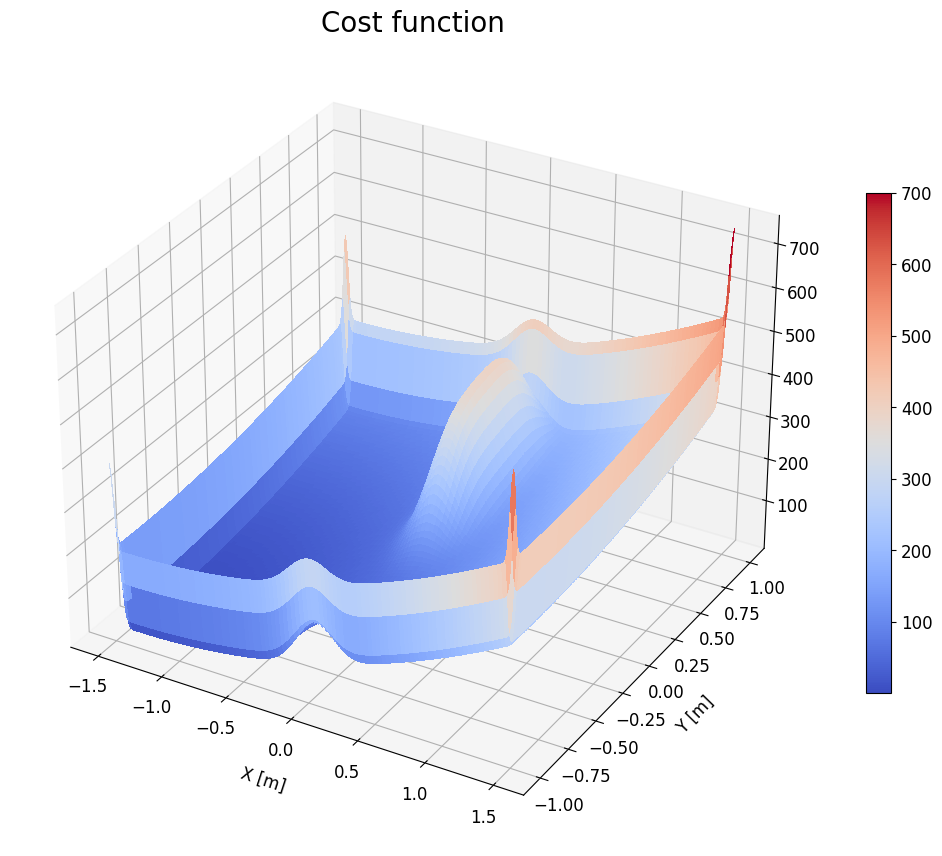

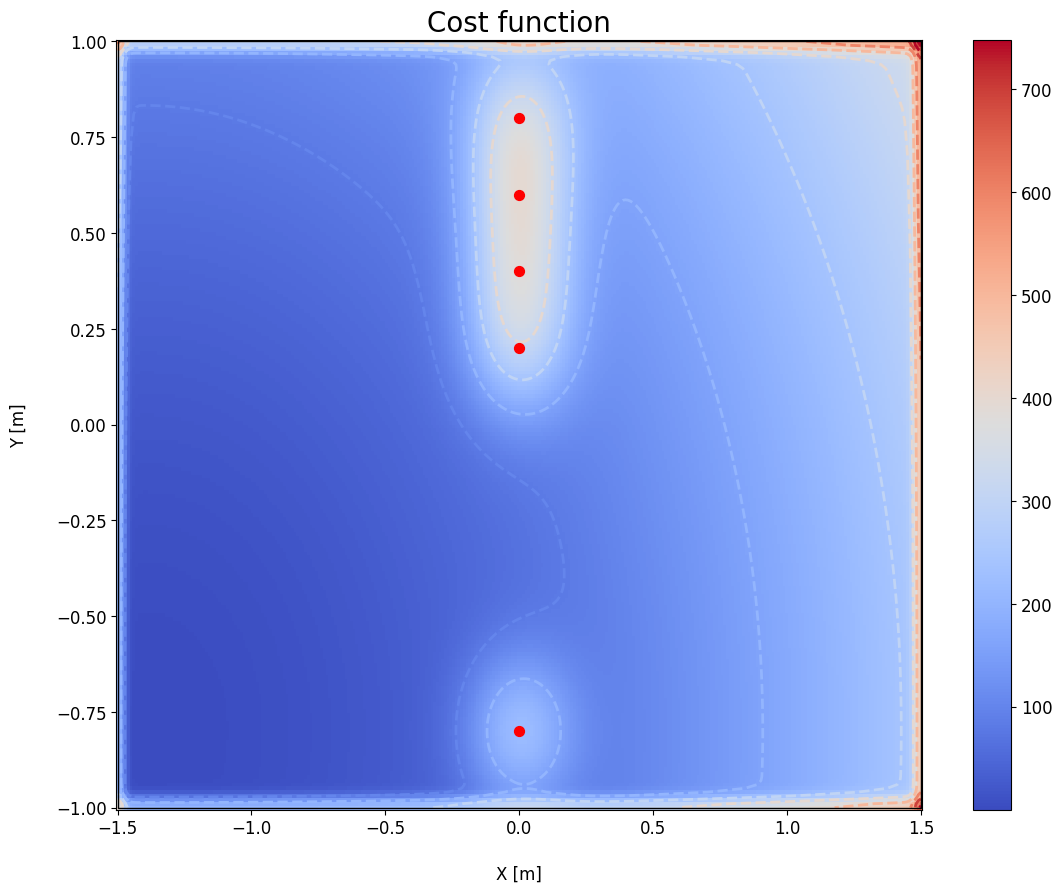

In [9]:
%matplotlib inline
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot()
ax.set_xlabel('X [m]', labelpad=20)
ax.set_ylabel('Y [m]', labelpad=20)
ax.set_title('Cost function', fontdict={'fontsize': 20})

# Plot the heatmap of the cost function
pcolormesh = ax.pcolormesh(X_grid, Y_grid, costs, cmap='coolwarm', shading='auto', zorder=1)

# Plot the level curves of the cost function
contour = ax.contour(X_grid, Y_grid, costs, cmap='coolwarm', levels=10, linewidths=2, linestyles='dashed', zorder=2, alpha=1, vmin=0, vmax=600) #vmin and vmax are used to make the contour lines more visible

# Scatter the obstacle points
ax.scatter(obs_points[0,:], obs_points[1,:], marker='o', s=50, color='red', zorder=3)

# Add a colorbar
fig.colorbar(pcolormesh, ax=ax) 

# Create a rectangle
rectangle = Rectangle((X_LIMITS[0], Y_LIMITS[0]), X_LIMITS[1]-X_LIMITS[0], Y_LIMITS[1]-Y_LIMITS[0], fill=False, color="black", linewidth=1, zorder=3)
# Add the rectangle to the plot
ax.add_patch(rectangle)

Plot the modules of the gradient of the cost function

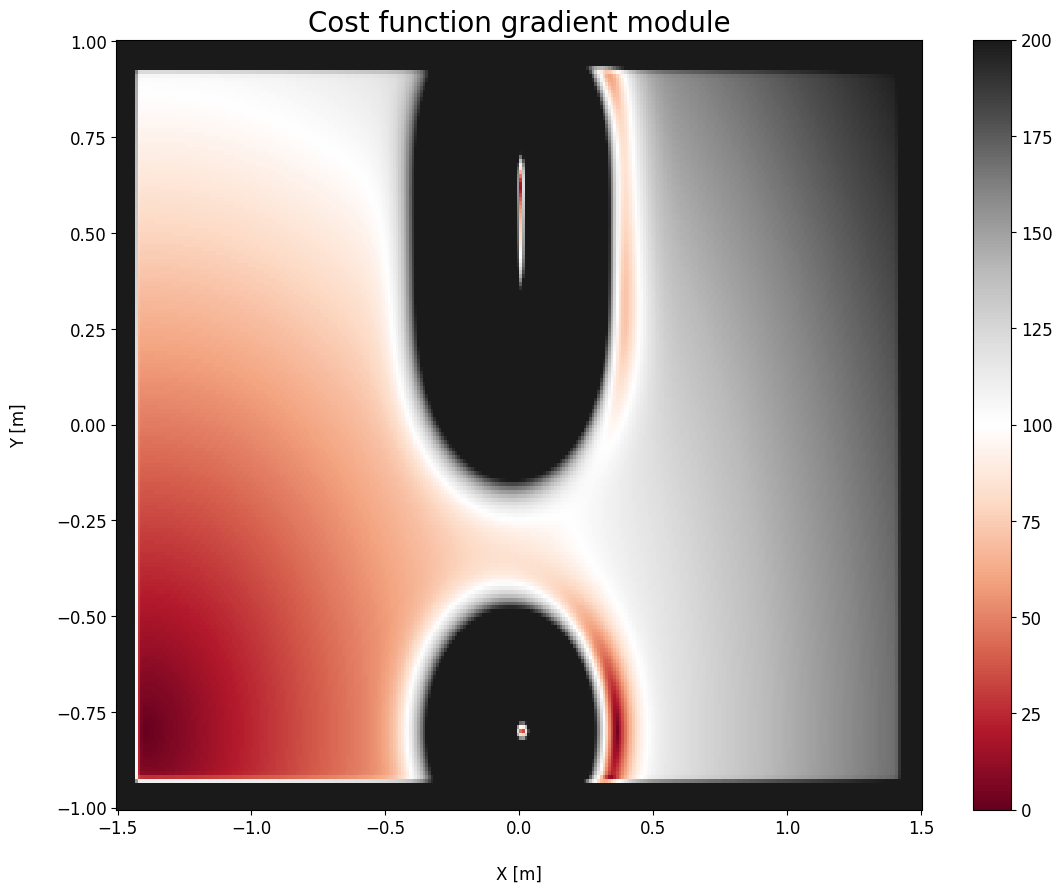

In [10]:
%matplotlib inline
# Calculate the gradient of the cost function
X_grad, Y_grad = np.gradient(costs.T, X_axis, Y_axis) #We need to transpose the costs matrix because we are passing the x axis as the first argument
# Calculate the module of the gradient
Z_grad = np.sqrt(X_grad**2 + Y_grad**2).T #We need to transpose the result because we need to plot it

fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot()
ax.set_xlabel('X [m]', labelpad=20)
ax.set_ylabel('Y [m]', labelpad=20)
ax.set_title('Cost function gradient module', fontdict={'fontsize': 20})

# Plot the heatmap of the module of the gradient of the cost function
pcolormesh = ax.pcolormesh(X_grid, Y_grid, Z_grad, zorder=1, cmap='RdGy', vmin=0, vmax=200)

# Add a colorbar
fig.colorbar(pcolormesh, ax=ax) 

# WP2

In [11]:
#WP2: Simulate (4 experiments) and visualize each robot's trajectory

In [12]:
%matplotlib tk
# Instantiate Robotarium object
N = 1 #Amount of robots per simulation
MAX_ITERATIONS = 5000 #Maximum number of iterations per experiment beceause the simulation is not guaranteed to converge
# Initial conditions of the robot for 4 experiments
initial_conditions = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))] #Initial pose of the robots


N_experiment = 4
# X_si is going to be two-dimensional state history
X_Si = [0]*N_experiment
# D_Xi is going to be two-dimensional inputs history
D_Xi = [0]*N_experiment

# This first for loop creates the initial conditions
for I in range(N_experiment):

    X_si = []
    D_xi = []
    #we use mp.copy to avoid that the initial conditions are modified by the simulation
    r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=np.copy(initial_conditions[I]), sim_in_real_time=False)

    # Create mapping from the control inputs to the actual velocity commands to the unicycle
    # Note: this is a very practical situation (robots often provide transformation functions to low level commands)
    si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion() #Converts single integrator inputs to unicycle inputs (low-level controller)
    _, uni_to_si_states = create_si_to_uni_mapping()
    
    # define x initially
    x = r.get_poses()
    x_si = uni_to_si_states(x)

    # Plotting Parameters
    CM = np.random.rand(N+10,3) # Random Colors
    goal_marker_size_m = 0.15
    obs_marker_size_m = 0.15
    marker_size_goal = determine_marker_size(r,goal_marker_size_m)
    marker_size_obs = determine_marker_size(r,obs_marker_size_m)
    font_size = determine_font_size(r,0.1)
    line_width = 5

    # Create Goal Point Markers
    #Text with goal identification
    goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
    #Plot text for caption
    goal_points_text = [r.axes.text(goal_points[0,ii], goal_points[1,ii], goal_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(goal_points.shape[1])]
    goal_markers = [r.axes.scatter(goal_points[0,ii], goal_points[1,ii], s=marker_size_goal, marker='s', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width,zorder=-2)
    for ii in range(goal_points.shape[1])]

    #Text with goal identification
    obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
    #Plot text for caption
    obs_points_text = [r.axes.text(obs_points[0,ii], obs_points[1,ii], obs_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(obs_points.shape[1])]
    obs_markers = [r.axes.scatter(obs_points[0,ii], obs_points[1,ii], s=marker_size_obs, marker='s', facecolors='none',edgecolors=CM[ii+1,:],linewidth=line_width,zorder=-2)
    for ii in range(obs_points.shape[1])]

    r.step()

    i = 0
    # While the robot is away from the objective ...
    while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.15,rotation_error=100)) != N and i < MAX_ITERATIONS ):

        # Get poses of agents
        x = r.get_poses()
        x_si = uni_to_si_states(x)

        #Add to the dataset
        X_si.append(x_si)

        # The lines below define the pdf of the robot 
        cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
        x_pdf = st.multivariate_normal(x_si.reshape((2,)),cov)
        x_sample = x_pdf.rvs() #Noisy state

        # This is about plotting
        for j in range(goal_points.shape[1]):
            goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])

        for j in range(obs_points.shape[1]):
            obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])

        # Task: compute the action from the policy. Call the variable dxi: 
        # this is the action sampled from the optimal solution to the control problem
        dxi = Control_step(x_sample, U_space_1, U_space_2, goal_points, obs_points)
        D_xi.append(dxi)

        # Transform single integrator velocity commands to unicycle inputs (low level controller)
        dxu = si_to_uni_dyn(dxi, x)

        # Set the velocities inputs
        r.set_velocities(np.arange(N), dxu)
        # Iterate the simulation
        r.step()
        
        i += 1

    if i >= MAX_ITERATIONS:
        print("SIMULATION {} FAILED!".format(I))
    
    D_Xi[I] = D_xi
    X_Si[I] = X_si

    #Call at end of script to print debug information and for your script to run on the Robotarium server properly
    r.call_at_scripts_end()
    plt.close()

##### DEBUG OUTPUT #####
Your simulation will take approximately 35 real seconds when deployed on the Robotarium. 

	 Simulation had 958 iteration(s) where the actuator limits were exceeded.
##### DEBUG OUTPUT #####
Your simulation will take approximately 34 real seconds when deployed on the Robotarium. 

	 Simulation had 1867 iteration(s) where the actuator limits were exceeded.
##### DEBUG OUTPUT #####
Your simulation will take approximately 40 real seconds when deployed on the Robotarium. 

	 Simulation had 2911 iteration(s) where the actuator limits were exceeded.
##### DEBUG OUTPUT #####
Your simulation will take approximately 35 real seconds when deployed on the Robotarium. 

	 Simulation had 3797 iteration(s) where the actuator limits were exceeded.


In [13]:
XX = X_Si #Insieme degli stati nel sistema single-integrator (y_1, y_2) per ogni simulazione
UU = D_Xi #Insieme delle azioni di controllo per ogni simulazione

In [14]:
#Prepare data for plotting
X = []
X_plot = []
U = []
U_plot = []

for i in range(len(XX)):
    X.append(np.array(XX[i])) #X=XX ma è un array di array numpy
    X_plot.append(np.array(XX[i])) #X_plot = XX ma è un array numpy
X = np.concatenate(X, axis=0) #X adesso è un array numpy. La prima dimensione contiene le traiettorie di tutti gli esperimenti concatenate e la secoda indicizza lo stato
X = np.reshape(X, (-1, 2)) # Rimuove l'ultima dimensione inutile
U = []
for i in range(len(UU)):
    U.append(np.array(UU[i])) #U=UU ma è un array di array numpy
    U_plot.append(np.array(UU[i])) #U_plot=UU ma è un array di array numpy

U = np.concatenate(U, axis=0) #Stessa cosa di prima per le traiettorie di ingresso
U = np.reshape(U, (-1, 2))

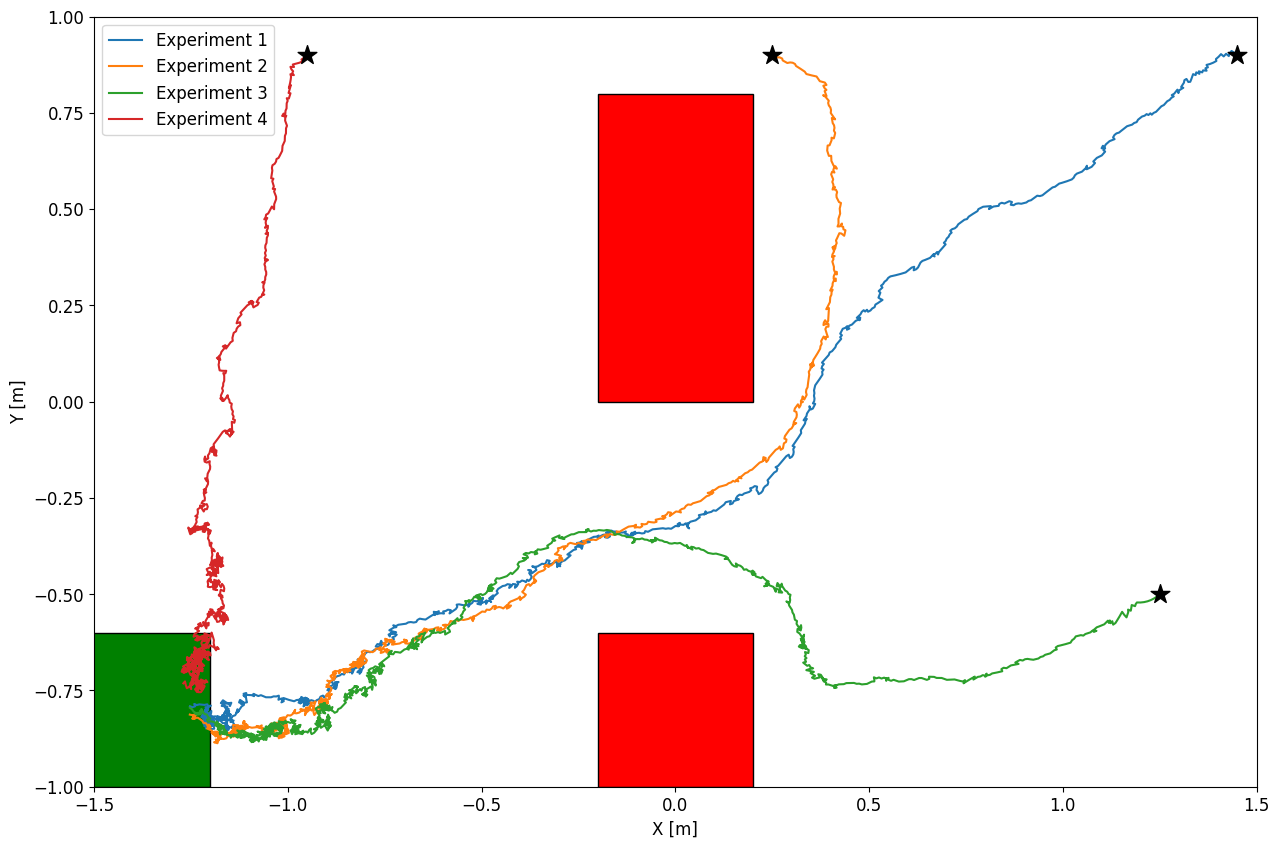

In [15]:
%matplotlib inline
#Task: plot trajectories with different colors
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

plt.figure(figsize=(15,10))

for I in range(N_experiment):
    trajectory = np.array(X_Si[I])
    plt.plot(trajectory[:,0],trajectory[:,1])

#Add a star to the starting point of each trajectory
for I in range(N_experiment):
    trajectory = np.array(X_Si[I])
    plt.scatter(trajectory[0,0], trajectory[0,1], marker='*', s=200, color='black', zorder=3)

#Add a legend to the plot
legend = []
for i in range(N_experiment):
    legend = legend + ['Experiment {}'.format(i+1)]
    plt.legend(legend)

#Draw obstacles
square1 = plt.Rectangle((-1.6,-1), 0.4, 0.4, fc='green',ec="black")
square3 = plt.Rectangle((-0.2,-1), 0.4, 0.4, fc='red',ec="black")
square2 = plt.Rectangle((-0.2,0), 0.4, 0.8, fc='red',ec="black")
plt.gca().add_patch(square2)
plt.gca().add_patch(square1)
plt.gca().add_patch(square3)
plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.savefig('Training_Trajectories.jpg',dpi=1000,bbox_inches ='tight')


In rosso si vedono i due ostacoli fisici, uno centrato in (0, -0.8) e un altro più lungo centrato in (0, 0.5).
In verde si vede approssimativamente il goal point, che nella funzione costo è una forma quadratica centrata in (-1.4, -0.8)

# WP3 

### Feature functions visualization

In [16]:
##### WP3: Reverse engineer the features and visualize them #####

In [17]:

#Redefining the feature points on the robotarium grid
obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))



Text(0.5, 1.0, 'Feature points')

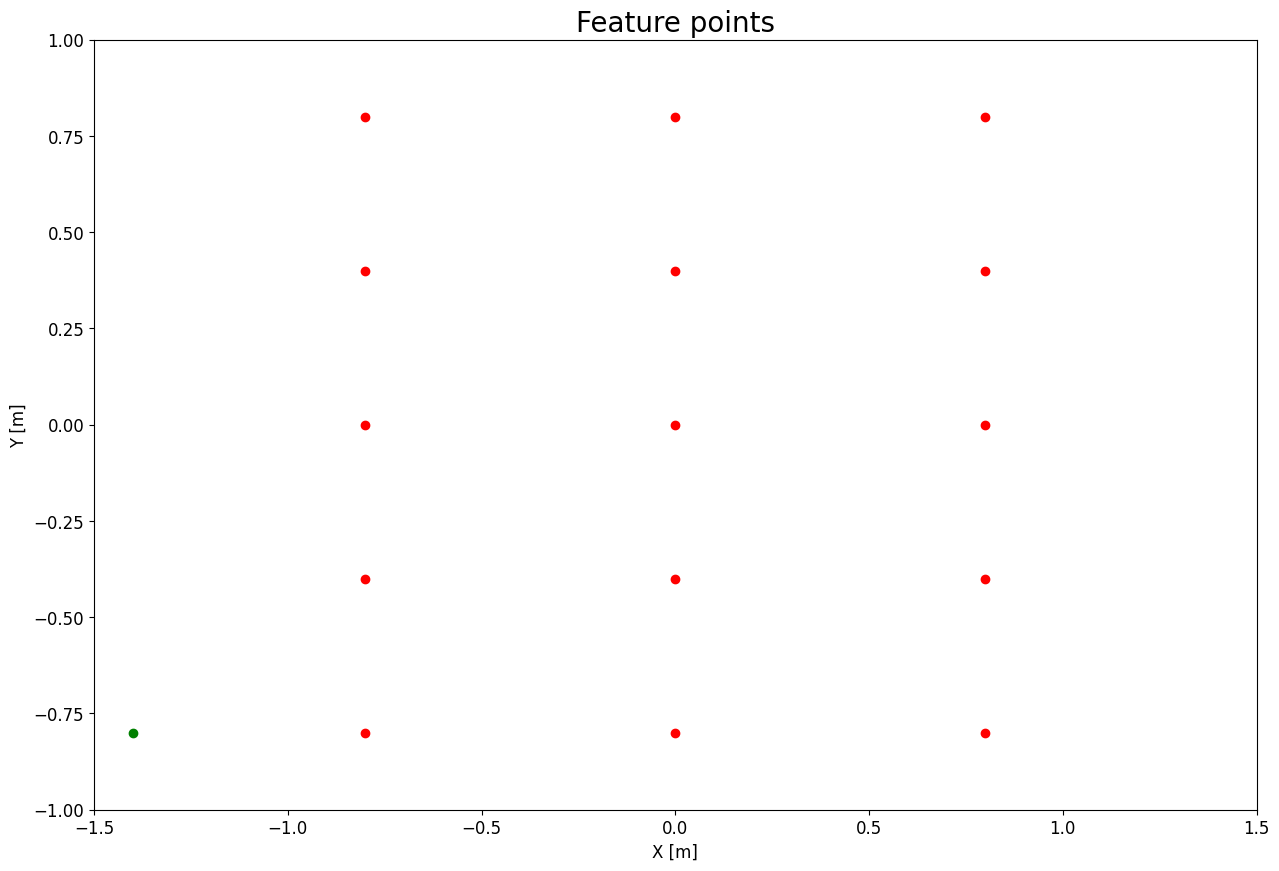

In [18]:
%matplotlib inline
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
ax.scatter(obs_points_f[0,:],obs_points_f[1,:], color='red')
ax.scatter(goal_points[0,:],goal_points[1,:], color='green')
ax.set_ylim(-1,1)
ax.set_xlim(-1.5,1.5)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('Feature points', fontdict={'fontsize': 20})

In [19]:
# Task: reverse engineer the features and critically discuss them

N_feature = np.size(obs_points_f,axis=1)+1 #16


"""
There are 16 features:
- The first one models the goal point.
- Another 15 model potential obstacles.

From what the 'feature' function will be called we infer that the location of the obstacles is unknown but the goal point is known.
"""

# Valuta il vettore di features [h(x_k)] nello stato x_k 
def feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32) #vettore delle varianze
    covar = np.diag(v) #matrice di varianze e covarianze
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar) #Modelliamo gli ostacoli come multivariate gaussiane indipendenti (cov=0) centrate nell'ostacolo ipotizzato

    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2)) #La prima feature è relativa al raggiungimento del goal point

    return features

/tmp/ipykernel_189798/2031857909.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2)) #La prima feature è relativa al raggiungimento del goal point


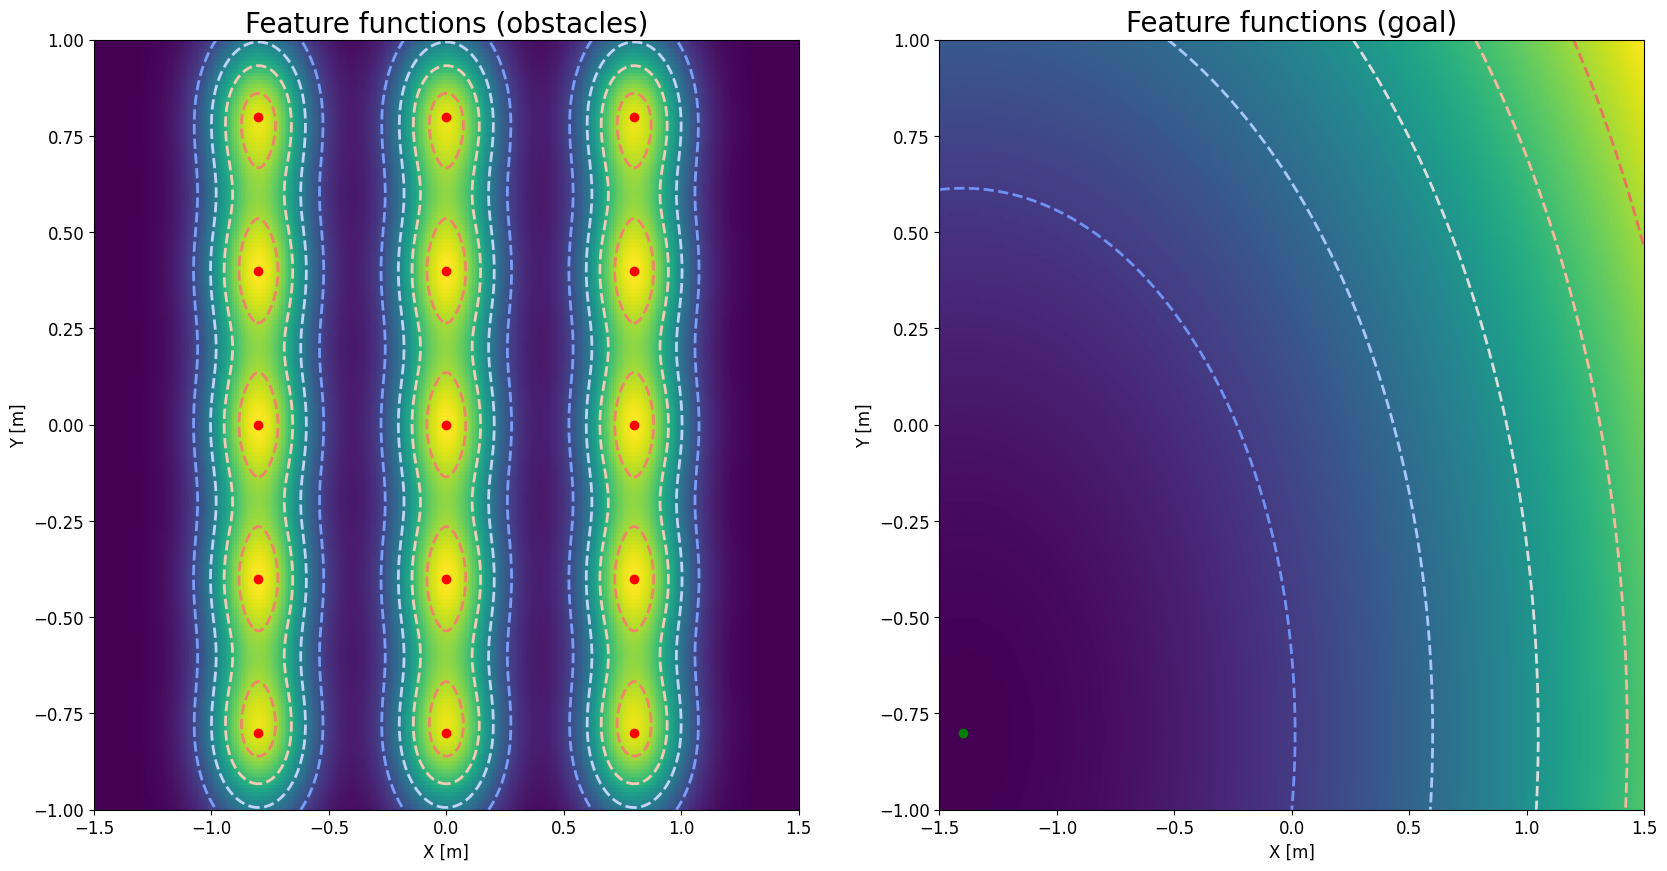

In [20]:
%matplotlib inline

# Define the grid of points where to evaluate the feature function
X_axis = np.linspace(X_LIMITS[0]-EPSILON_LIMITS, X_LIMITS[1]+EPSILON_LIMITS, 300)
Y_axis = np.linspace(Y_LIMITS[0]-EPSILON_LIMITS, Y_LIMITS[1]+EPSILON_LIMITS, 200)
X_grid, Y_grid = np.meshgrid(X_axis, Y_axis)

# Calculate the feature function on the grid
features_array = np.array([[feature((x,y),goal_points,obs_points_f,N_feature) for x in X_axis] for y in Y_axis] ) #TODO: speed up this line by vectorizing it


# Plot the feature functions for the obstacles
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('Feature functions (obstacles)', fontdict={'fontsize': 20})
ax.set_xlim(X_LIMITS[0],X_LIMITS[1])
ax.set_ylim(Y_LIMITS[0],Y_LIMITS[1])

ax.scatter(obs_points_f[0,:],obs_points_f[1,:], color='red', zorder=3)


Z = np.sum(features_array[:,:,1:], axis=-1)
colormesh = ax.pcolormesh(X_grid, Y_grid, Z, shading='auto', zorder=1)
ax.contour(X_grid, Y_grid, Z, cmap='coolwarm', levels=5, linewidths=2, linestyles='dashed', alpha=1, zorder=2) #vmin and vmax are used to make the contour lines more visible

# Plot feature function for the goal
ax = fig.add_subplot(1,2,2)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('Feature functions (goal)', fontdict={'fontsize': 20})
ax.set_xlim(X_LIMITS[0],X_LIMITS[1])
ax.set_ylim(Y_LIMITS[0],Y_LIMITS[1])

ax.scatter(goal_points[0,:],goal_points[1,:], color='green', zorder=3)


Z = features_array[:,:,0]
colormesh = ax.pcolormesh(X_grid, Y_grid, Z, shading='auto', zorder=1)
ax.contour(X_grid, Y_grid, Z, cmap='coolwarm', levels=5, linewidths=2, linestyles='dashed', alpha=1, zorder=2) #vmin and vmax are used to make the contour lines more visible


# WP4

In [21]:
##### WP4: using the previously defined features solve the inverse optimal control problem. 
#          Plot the estimated cost. 
#          Verify that the estimated cost allows the robot to complete the task #####

In [22]:
%%capture
'''
Solving the convex optimisation problem to learn the cost.
'''
import cvxpy as cp
import numpy as np
import time
M = np.size(X,axis=0) - 1 #size è la lunghezza di tutte le simulazioni concatenate. Concatenare le simulazioni genera 4 termini spuri.
w = cp.Variable((1,N_feature)) #Variabili decisionali. Sono tante quanto il numero di features.
constraints = [w >= 0] #Per hp del problema.
R = np.zeros((99,1)) #??? Mai usato
L = [] #Termini della funzione target da minimizzare (la funzione da minimizzare sum(L))

f_expect = np.zeros((2,20)) #???
feature_sampled = np.zeros((N_feature,M)) #Questo è il valore atteso a sinistra in blu (tranne la moltiplicazione per w che si può portare fuori)
PF = np.zeros((control_space_size,control_space_size,M)) #Questa è la funzione q soprasegnato indicizzata in (u_k, k) dove k è l'indice temporale

for i in range(M): #i è l'i-esimo termine della funzione target da ottimizzare (somma da 1 a M), sto fissando x hat 

    #############################################################################################################################
    features = np.zeros((N_feature,control_space_size,control_space_size)) #Questo è il valore atteso a destra in verde (tranne la moltiplicazione per w che si può portare fuori)
    state = np.array(X[i,:]) #Get the state \hat x_k-1

    x0 = state.reshape(-1,1) #è equivalente alla flatten(), x0 è lo stato iniziale (x0[0],x0[1])
    time_step = 0.033


    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf \overline q(u)

    for j in range(control_space_size):
        for k in range(control_space_size):
            next_state = model_step(state,[U_space_1[j],U_space_2[k]],time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov) #p(x_k|\hat x_k-1, u_k) valutata per \hat x_k-1 e u_k fissati
            #next_sample = f.mean #next_sample = next_state, inutile

            N_samples = 5
            next_samples = f.rvs(N_samples) #5 campioni relativi al prossimo stato. Dimensione 5 campioni x 2 variabili di stato
            feature_sample = np.zeros((N_feature,N_samples)) # 16 feature x 5 campioni

            for m in range(N_samples):
                feature_sample[:,m] = feature(next_samples[m,:],goal_points,obs_points_f,N_feature) #feature_sample è una matrice che tiene sulle colonne le valutazioni delle features sui campioni. Le colonne rorrispondono ai campioni.

            features[:,j,k] = np.mean(feature_sample,axis=1) #la media è fatta su tutti gli elementi della riga [i,;], ovvero per ogni feature i-esima faccio la media su tutti i campioni
            #Alla fine del ciclo features contiene la stima del valore atteso delle features per ogni possibile ingresso (j,k) con \hat x_k-1 fissato
            #quindi ho tutte le stime dei valori attesi a destra in verde nell'equazione. Fatta con la legge dei grandi numeri.
            #Calculate the DKL for each possible input, get corresponding probability
            log_DKL = np.exp(-(-f.entropy())) #Prima parte del valore atteso a destra
            pf[j,k] = log_DKL
    PF[:,:,i] = pf #Prima parte del valore atteso a destra per ogni valore di ingresso e u_k e stato x_k-1

    features = np.reshape(features,(N_feature,control_space_size**2)) # Adesso features ha come primo indice la feature e il secondo va da 0 a 8 e indica l'ingresso di controllo

    f_sampled = model_step(state,U[i+1,:],time_step) # Costuiramo la pdf p(x_k|\hat x_k-1,\hat u_k) che serve a calcolare il valore atteso a sinistra in blu
    cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
    f1 = st.multivariate_normal(f_sampled.reshape((2,)),cov) #p(x_k|\hat x_k-1,\hat u_k)
    next_samples_f1 = f1.rvs(N_samples) #stessa cosa di prima, stima con legge dei grandi numeri del expectation blu a sinistra
    feature_sample_f1 = np.zeros((N_feature,N_samples))
    for n in range(N_samples):
        feature_sample_f1[:,n] = feature(next_samples_f1[n,:],goal_points,obs_points_f,N_feature)

    feature_sampled[:,i] = np.mean(feature_sample_f1,axis=1)  # features_sampled è la stessa cosa di features fatta sul valore atteso blu. nota che u è fissata qunidi non ho come indici j e k. Ho i come indice ed è inutile.

    # Task: solve, using cvx the convex optimization problem we saw in class. To do so:
    # (i) prepare each individual term of the summation, say l;
    # (ii) sum all the elements to define the cost function
    # (iii) solve the problem
    PF2 = np.reshape(PF,(-1,M))
    # log_sum_exp prende in ingresso il vettore colonna degli elmenti da sommare
    l = -(w @ feature_sampled[:,i]) + cp.log_sum_exp(cp.reshape(w@features[:,:],(control_space_size**2,)) + cp.log(PF2[:,i])) #(i)
    L.append(l) #(ii)

objective = cp.Minimize(cp.sum(L)) #(iii)

prob = cp.Problem(objective)

result = prob.solve(verbose = True)

print("status:", prob.status)
print("optimal value", prob.value)


ECOS 2.0.10 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -9.020e+04  +1e+05  4e-01  3e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  -3.835e+03  -4.066e+04  +5e+04  1e-01  1e+00  4e-01  4e-01  0.6266  5e-02   1  1  1 |  2  2
 2  -5.826e+03  -2.645e+04  +3e+04  4e-02  6e-01  2e-01  2e-01  0.5013  1e-01   1  1  0 |  3  3
 3  -6.942e+03  -1.968e+04  +2e+04  2e-02  4e-01  1e-01  1e-01  0.5013  2e-01   1  1  0 |  4  3
 4  -7.803e+03  -1.455e+04  +8e+03  1e-02  2e-01  7e-02  7e-02  0.6266  2e-01   1  0  0 |  4  2
 5  -8.390e+03  -1.083e+04  +3e+03  5e-03  7e-02  3e-02  2e-02  0.7833  1e-01   1  1  1 |  3  1
 6  -8.455e+03  -1.012e+04  +2e+03  4e-03  5e-02  2e-02  1e-02  0.5013  3e-01   1  0  0 |  4  3
 7  -8.492e+03  -9.530e+03  +1e+03  3e-03  3e-02  1e-02  8e-03  0.7833  5e-01   1  1  0 |  6  1
 8  -8.483e+03  -9.495e+03  +9e+02  3e-03  3e

In [23]:
# Show the values: critically discuss if these weights make sense
weights = w.value

print('weights:',weights)

weights: [[-10.52549874  -5.35102456   0.13956784  -0.17820865 -12.27900511
   -7.50575924   0.22376293   0.0724772    0.02389071  -0.77563601
   -0.41025138  -0.10468469   0.06457492  -2.07655941  -0.45747366
   -0.25404061]]


In [24]:
# Check the status of the optimization problem: did the optimization go well? Si
print("status:", prob.status)
print("optimal value", prob.value)

status: optimal
optimal value -8602.392337075136


### Plot the estimated cost function

In [25]:
# Reformatting the original cost map (just for checking and plotting purposes)

import numpy as np
import scipy.stats as st
import pandas as pd

goal_points = np.array(np.mat('-1.4; -0.8; 0'))

#obs_points = np.array(np.mat('0 0 0 0 0 0;0 0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0 0'))
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))

def state_cost(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost(state,goal_points,obs_points)

# we delete this row because we understand that it is not used
#Coat_Map = pd.DataFrame(Cost_Map,index=list(X_axis),columns=Y_axis)

/tmp/ipykernel_189798/2217714915.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Cost_Map[j,i] = state_cost(state,goal_points,obs_points)


In [26]:
# Computing the reconstructed cost map

import numpy as np
import scipy.stats as st

#goal_points = np.array(np.mat('-1.4; -0.8; 0'))

def state_cost_estimated(state,goal_points,obs_points,weights):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1]*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

/tmp/ipykernel_189798/4090227821.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)


Heatmap of the estimated cost function

/tmp/ipykernel_189798/420749755.py:19: UserWarning: The following kwargs were not used by contour: 'shading'
  contour = ax.contour(X_axis, Y_axis, data_rotated, cmap='coolwarm', shading='linear', levels=7, linewidths=2, linestyles='dashed', zorder=2, alpha=1, vmin=40, vmax=100) #vmin and vmax are used to make the contour lines more visible


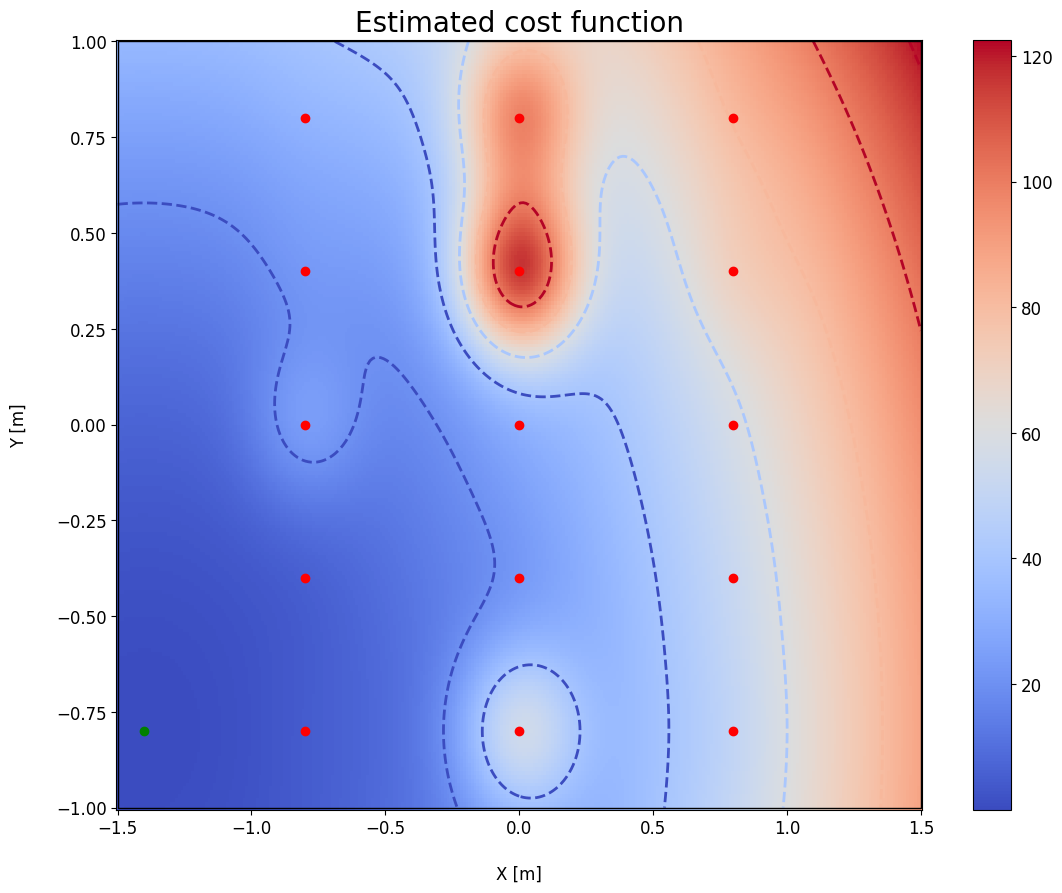

In [27]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.colors import CenteredNorm
# Transpose the data array to rotate the heatmap
data_rotated = np.transpose(Cost_Map) 
 
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot()
ax.set_xlabel('X [m]', labelpad=20)
ax.set_ylabel('Y [m]', labelpad=20)
ax.set_title('Estimated cost function', fontdict={'fontsize': 20})

# Plot the heatmap of the cost function
pcolormesh = ax.pcolormesh(X_axis, Y_axis, data_rotated, cmap='coolwarm', shading='auto', zorder=1)

# Plot the level curves of the cost function
contour = ax.contour(X_axis, Y_axis, data_rotated, cmap='coolwarm', shading='linear', levels=7, linewidths=2, linestyles='dashed', zorder=2, alpha=1, vmin=40, vmax=100) #vmin and vmax are used to make the contour lines more visible

# Add a colorbar
fig.colorbar(pcolormesh, ax=ax)

# Create a rectangle
rectangle = Rectangle((X_LIMITS[0], Y_LIMITS[0]), X_LIMITS[1]-X_LIMITS[0], Y_LIMITS[1]-Y_LIMITS[0], fill=False, color="black", linewidth=1, zorder=3)
# Add the rectangle to the plot
ax.add_patch(rectangle)
 
plt.scatter(obs_points_f[0,:],obs_points_f[1,:], color='red', zorder=3)
plt.scatter(goal_points[0,:],goal_points[1,:], color='green', zorder=3)

plt.show()




3D plot of the estimated cost function

In [28]:
%matplotlib tk
# Create a 3D plot
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('X [m]', labelpad=10)
ax.set_ylabel('Y [m]', labelpad=10)
ax.set_zlabel('Cost')
ax.set_title('Estimated Cost Function', fontdict={'fontsize': 20})

surf = ax.plot_surface(X_grid, Y_grid, data_rotated, cmap=cm.coolwarm, linewidth=0, antialiased=False, ccount=100, rcount=100) #rcount and ccount are used to make the surface smoother
fig.colorbar(surf, shrink=0.5)
plt.show()



### Simulation with the estimated cost function

In [29]:
#TODO: delete interpolated cost

We calculate an interpolation of the cost function to speed up the computation of the policy ---- da togliere prima  di consegnare

In [30]:
from scipy import interpolate

X_axis_interpolation = np.linspace(X_LIMITS[0]-0.5, X_LIMITS[1]+0.5, 600)
Y_axis_interpolation = np.linspace(Y_LIMITS[0]-0.5, Y_LIMITS[1]+0.5, 400)
X_grid_interpolation, Y_grid_interpolation = np.meshgrid(X_axis_interpolation, Y_axis_interpolation)
Z = np.zeros((600,400))
for i in range(600):
    for j in range(400):
        Z[i,j] = state_cost_estimated(np.array([X_axis_interpolation[i],Y_axis_interpolation[j]]),goal_points,obs_points_f,weights)

# interpolated_costs = griddata((X_interpolation.flatten(),Y_interpolation.flatten()), Z.flatten(), (X_interpolation.flatten(), Y_interpolation.flatten()), method='cubic').reshape(dense_X.shape)

# Cost_Map_2 = np.zeros((600,400))
# X_axis_2 = np.linspace(-3.0,3.0,600)
# Y_axis_2 = np.linspace(-2,2,400)

# for i in range(400):
#     for j in range(600):
#         state = np.array([X_axis_2[j],Y_axis_2[i]])
#         Cost_Map_2[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

# interpolated_cost = interpolate.RegularGridInterpolator((X_axis_2, Y_axis_2), Cost_Map_2)
# interpolated_cost([1.49,1.0])

interpolated_cost = interpolate.LinearNDInterpolator(np.stack((X_grid_interpolation.flatten(),Y_grid_interpolation.flatten()),axis=1),Z.T.flatten())

/tmp/ipykernel_189798/1076082319.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i,j] = state_cost_estimated(np.array([X_axis_interpolation[i],Y_axis_interpolation[j]]),goal_points,obs_points_f,weights)


Plot the interpolated cost function

In [31]:
#Plot the heatmap of the interpolated cost function
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot()
ax.set_xlabel('X [m]', labelpad=20)
ax.set_ylabel('Y [m]', labelpad=20)
ax.set_title('Interpolated cost function', fontdict={'fontsize': 20})
TEST = np.zeros((600,400))

for i in range(600):
    for j in range(400):
        TEST[i,j] = interpolated_cost(X_axis_interpolation[i], Y_axis_interpolation[j])
pcolormesh = ax.pcolormesh(X_grid_interpolation, Y_grid_interpolation, TEST.T, cmap='coolwarm',  zorder=1)


In [32]:
#Task: re-define the function Control_step so that it now uses the estimated cost
def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
    ###
    # Perform a control step given the fact that the target pf is uniform.
    # The function first gets the target pf (uniform) and then applies the control solution we saw in class
    
    target_pf = 1/control_space_size**2 # Uniform pf q(u_k|x_k-1)
    time_step = 0.033 # The Robotarium time-step

    pf = np.zeros((control_space_size,control_space_size))
    for i in range(control_space_size):
        for j in range(control_space_size):
            next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov)
            N_samples = 20
            next_sample = f.rvs(N_samples) 

            # Task: what do the next three lines do?
            # Calcola una stima del valore atteso del costo nello stato successivo rispetto alla funzione f(x_k|x_k-1,u_k) usando 20 campioni
            cost=0
            for k in range(N_samples):
                #cost += state_cost_estimated(next_sample[k,:],goal_points,obs_points_f,weights)/N_samples
                cost += interpolated_cost(next_sample[k,:])/N_samples
            log_DKL = np.exp(f.entropy()-cost).item() #item is used to convert the result to a scalar
            pf[i,j] = log_DKL 
    # Task: obtain the normalizer for the policy, call it S2
    S2 = np.sum(pf)
    # Task: obtain the normalized pf (call the variable pf)
    pf = np.divide(pf,S2)

    # Adesso abbiamo p(u_k|x_{k-1}) e facciamo il sampling della prossima azione di controllo
    # This is a trick to properly sample from the multi-dimensional pf
    flat = pf.flatten()
    sample_index = np.random.choice(a=flat.size, p=flat)
    # Take this index and adjust it so it matches the original array
    adjusted_index = np.unravel_index(sample_index, pf.shape) #Indice dell'azione

    #Formatta l'azione come vettore colonna
    action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))
    return(action)

In [33]:
%matplotlib tk
# Instantiate Robotarium object (start the robots from different initial conditions than the 4 experiments above)
N = 1

MAX_ITERATIONS = 5000
initial_conditions = [np.array(np.mat('-1.4;0.9; 0')),np.array(np.mat('1;0.9; 0')),np.array(np.mat('1;-0.25; 0'))]
N_experiment = 3
# X_si is going to be two-dimensional state history
X_Si = [0]*N_experiment
# D_Xi is going to be two-dimensional inputs history
D_Xi = [0]*N_experiment

# This first for loop creates the initial conditions

for I in range(N_experiment):

    X_si = []
    D_xi = []

    r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=np.copy(initial_conditions[I]), sim_in_real_time=False)

    si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion()

    x = r.get_poses()
    x_si = uni_to_si_states(x)

    CM = np.random.rand(N+10,3) 
    goal_marker_size_m = 0.15
    obs_marker_size_m = 0.15
    marker_size_goal = determine_marker_size(r,goal_marker_size_m)
    marker_size_obs = determine_marker_size(r,obs_marker_size_m)
    font_size = determine_font_size(r,0.1)
    line_width = 5

    goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
    goal_points_text = [r.axes.text(goal_points[0,ii], goal_points[1,ii], goal_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(goal_points.shape[1])]
    goal_markers = [r.axes.scatter(goal_points[0,ii], goal_points[1,ii], s=marker_size_goal, marker='s', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width,zorder=-2)
    for ii in range(goal_points.shape[1])]

    obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
    obs_points_text = [r.axes.text(obs_points[0,ii], obs_points[1,ii], obs_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
    for ii in range(obs_points.shape[1])]
    obs_markers = [r.axes.scatter(obs_points[0,ii], obs_points[1,ii], s=marker_size_obs, marker='s', facecolors='none',edgecolors=CM[ii+1,:],linewidth=line_width,zorder=-2)
    for ii in range(obs_points.shape[1])]

    r.step()
    i = 0
    # While the robot is away from the objective ...
    while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.15,rotation_error=100)) != N and i < MAX_ITERATIONS ):

        # Get poses of agents
        x = r.get_poses()
        x_si = uni_to_si_states(x)

        #Add to the dataset
        X_si.append(x_si)

        # The lines below define the pdf of the robot 
        cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
        x_pdf = st.multivariate_normal(x_si.reshape((2,)),cov)
        x_sample = x_pdf.rvs() #Noisy state

        # This is about plotting
        for j in range(goal_points.shape[1]):
            goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])

        for j in range(obs_points.shape[1]):
            obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])

        # Task: compute the action from the policy. Call the variable dxi: 
        # this is the action sampled from the optimal solution to the control problem
        dxi = Control_step(x_sample, U_space_1, U_space_2, goal_points, obs_points)
        D_xi.append(dxi)

        # Transform single integrator velocity commands to unicycle inputs (low level controller)
        dxu = si_to_uni_dyn(dxi, x)

        # Set the velocities inputs
        r.set_velocities(np.arange(N), dxu)
        # Iterate the simulation
        r.step()
        
        i+=1
      

    D_Xi[I] = D_xi
    X_Si[I] = X_si

    r.call_at_scripts_end()
    plt.close()

##### DEBUG OUTPUT #####
Your simulation will take approximately 52 real seconds when deployed on the Robotarium. 

	 Simulation had 5152 iteration(s) where the actuator limits were exceeded.
##### DEBUG OUTPUT #####
Your simulation will take approximately 166 real seconds when deployed on the Robotarium. 

	 Simulation had 9461 iteration(s) where the actuator limits were exceeded.
##### DEBUG OUTPUT #####
Your simulation will take approximately 145 real seconds when deployed on the Robotarium. 

	 Simulation had 13246 iteration(s) where the actuator limits were exceeded.


In [34]:
XX = X_Si
UU = D_Xi

In [35]:
X = []
X_plot = []
U = []
U_plot = []

for i in range(len(XX)):
    X.append(np.array(XX[i]))
    X_plot.append(np.array(XX[i]))

X = np.concatenate(X, axis=0)
X = np.reshape(X, (-1, 2))

U = []
for i in range(len(UU)):
    U.append(np.array(UU[i]))
    U_plot.append(np.array(UU[i]))

U = np.concatenate(U, axis=0)
U = np.reshape(U, (-1, 2))

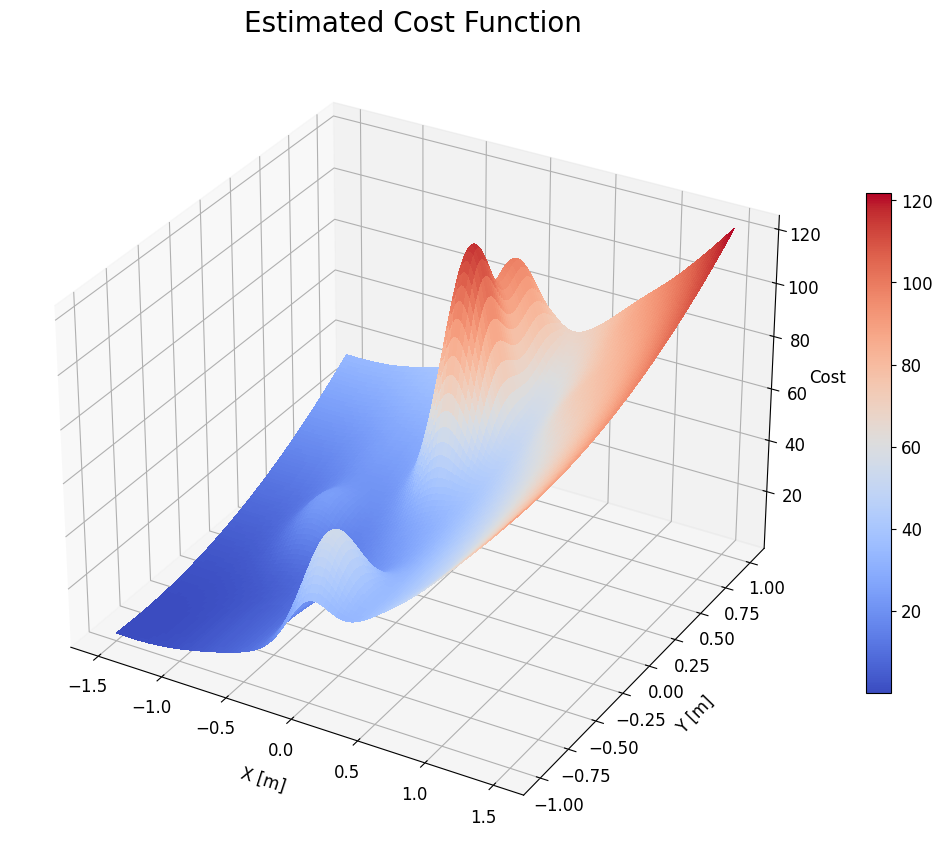

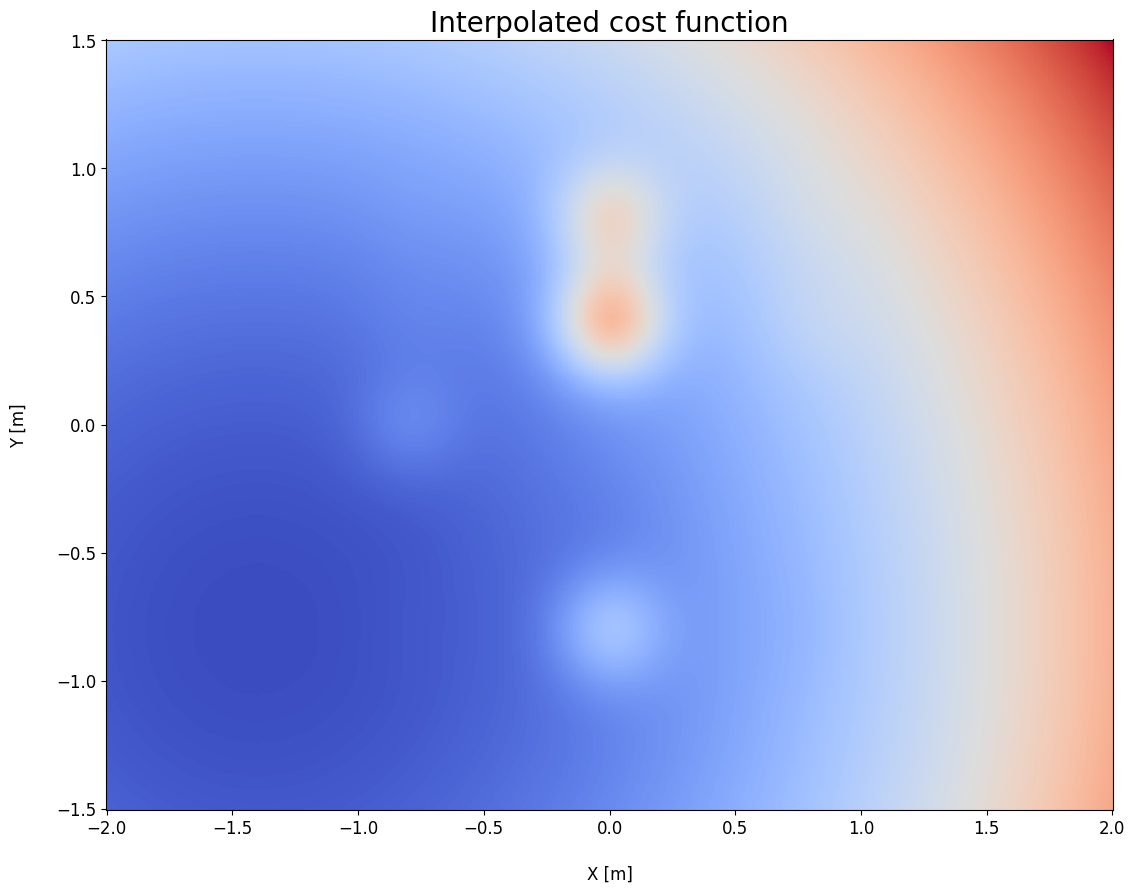

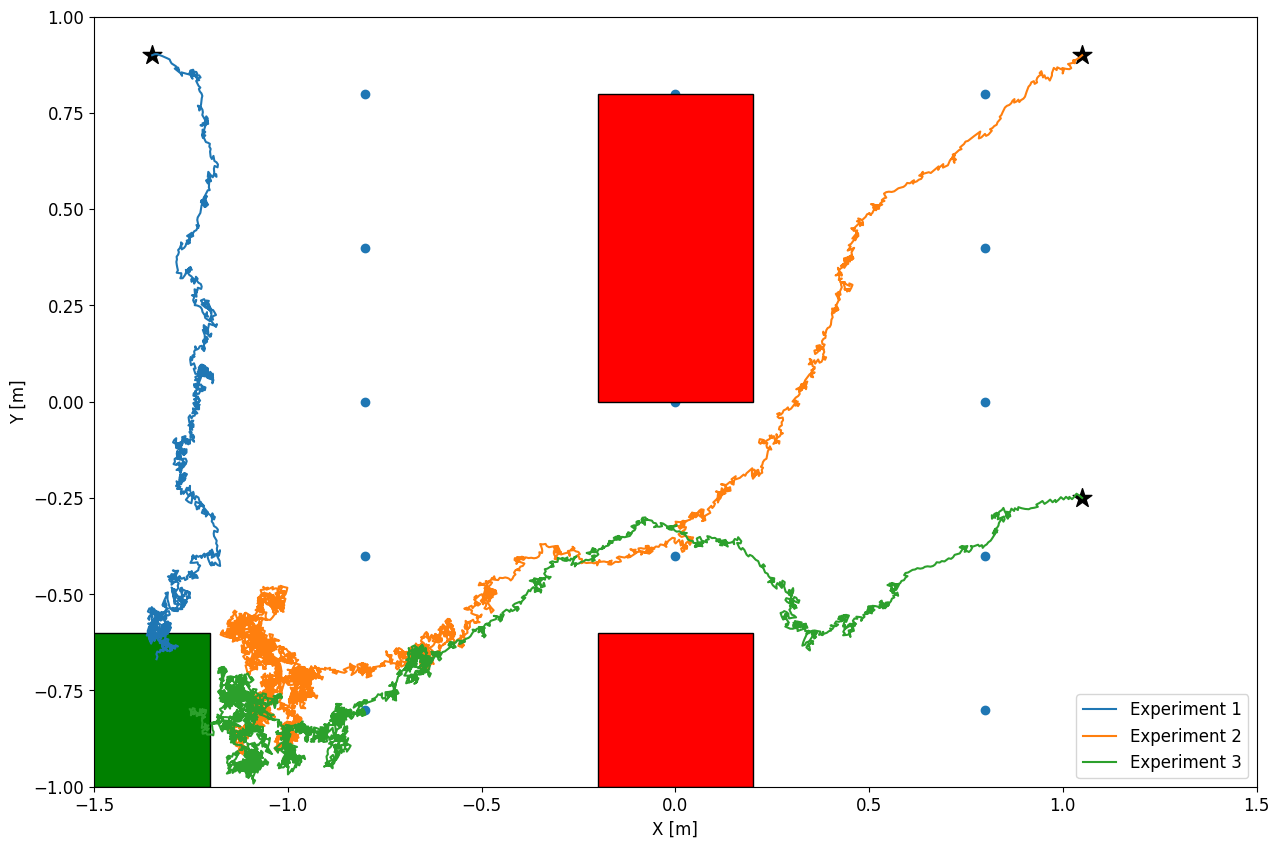

In [36]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
%matplotlib inline
#Task: plot trajectories with different colors
plt.figure(figsize=(15,10))

for I in range(N_experiment):
    trajectory = np.array(X_Si[I])
    plt.plot(trajectory[:,0],trajectory[:,1])

# Add a star to the starting point of each trajectory
for I in range(N_experiment):
    trajectory = np.array(X_Si[I])
    plt.scatter(trajectory[0,0], trajectory[0,1], marker='*', s=200, color='black')

# Add a legend to the plot
legend = []
for i in range(N_experiment):
    legend = legend + ['Experiment {}'.format(i+1)]
    plt.legend(legend)


#Draw goal point
square = plt.Rectangle((float(goal_points[0][0])-0.15,float(goal_points[1][0])-0.15), 0.3, 0.3, fc='green',ec="black") # Obiettivo da raggiungere
plt.gca().add_patch(square)

plt.scatter(obs_points_f[0,:],obs_points_f[1,:])

#Draw obstacles
square1 = plt.Rectangle((-1.6,-1), 0.4, 0.4, fc='green',ec="black")
square3 = plt.Rectangle((-0.2,-1), 0.4, 0.4, fc='red',ec="black")
square2 = plt.Rectangle((-0.2,0), 0.4, 0.8, fc='red',ec="black")
plt.gca().add_patch(square2)
plt.gca().add_patch(square1)
plt.gca().add_patch(square3)
plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.show()

[[-10.52549874  -5.35102456   0.13956784  -0.17820865 -12.27900511
   -7.50575924   0.22376293   0.0724772    0.02389071  -0.77563601
   -0.41025138  -0.10468469   0.06457492  -2.07655941  -0.45747366
   -0.25404061]]


(-1.0, 1.0)

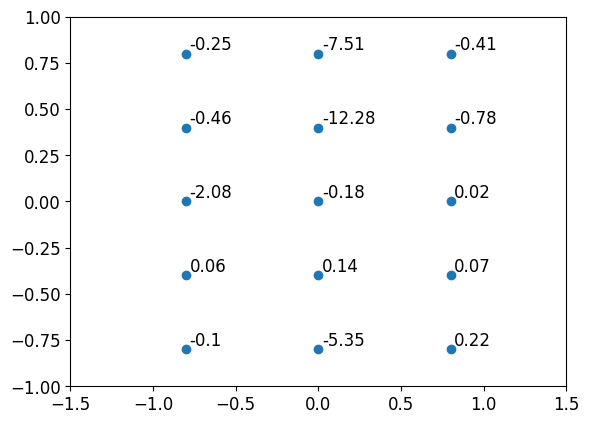

In [37]:
# Task: plot the feature points on the robotarium grid with corresponding weights
%matplotlib inline

import matplotlib.pyplot as plt
print(weights)
fig, ax = plt.subplots()
ax.scatter(obs_points_f[0,:],obs_points_f[1,:])
for i, w in enumerate(weights[0,1:]):
    ax.annotate(round(w,2), (obs_points_f[0,i] + 0.02, obs_points_f[1,i] + 0.02))

# Set x-axis limits
ax.set_xlim([-1.5, 1.5])

# Set y-axis limits
ax.set_ylim([-1, 1])

In [38]:
# Comment the results you observe in the figure generated by the above cell

# WP5

## Refactoring the code

In [73]:
#REDEFINING THE OLD FUNCTION:

import rps.robotarium as robotarium
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.misc import *
from rps.utilities.controllers import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

import scipy.stats as st
import time
import numpy as np
# Defining the input axes
# Note: the boundaries for the control actions are the actuation constraints imposed by the physics of the robots

control_space_size = 3  # Three possible inputs for each control axis

U_space_1 = np.array(np.linspace((-0.5),(0.5),control_space_size)) # Control space for the first axis
U_space_2 = np.array(np.linspace((-0.5),(0.5),control_space_size)) # Control space for the second axis
time_step = 0.033 # Robotarium time-step (from the documentation)


# This function performs a "model" step using the documented dynamics
# Note: from the viewpoint of the controller the dynamics is not necesarily known
def model_step(x,velocities,time_step):
    """This function calculates the next pose of the robots based on the current pose, the velocities and the simulation time-step.
    Args:
        x : The current position of the robot. 2x1 column vector .
        velocities : The velocities of the robot along the two control axes. 2x1 column vector. 
        time_step : simulation time-step
    Returns:
        The next pose of the robot as a 2x1 column vector.
    """
    poses = np.zeros((2,1))
    # Update pose of the robots
    poses[0] = x[0] + time_step*velocities[0]
    poses[1] = x[1] + time_step*velocities[1]
    return(poses)

#Get the value of a Gaussian pf at a given point x, with mean u and covariance covar
def my_logpdf(x, u, covar):
    """This function calculates the value of a multivariate Gaussian pdf at a given point x, with mean u and covariance covar

    Args:
        x : The point at which the pdf is evaluated. Nx1 column vector.
        u : The mean vector of the Gaussian distribution. Nx1 column vector.
        covar : The covariance matrix of the Gaussian distribution. NxN matrix.

    Returns:
        The value of the Gaussian pdf at x.
    """
    k = len(x)  # dimension
    a = np.transpose(x - u)
    b = np.linalg.inv(covar)
    c = x - u
    d = np.matmul(a, b)
    e = np.matmul(d, c)
    numer = np.exp(-0.5 * e)
    f = (2 * np.pi)**k
    g = np.linalg.det(covar)
    denom = np.sqrt(f * g)
    pdf = numer / denom
    return pdf


##### WP0: formalize the control problem #####

# Task: reverse engineer the cost function used by the robots. What is the problem formulation? 
#      Is the one below a good cost for the task? Create a heatmap to visualize the cost 

def state_cost(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    return(cost)

##### WP1: fill-in the code for the function below.
#         The function needs to return the optimal action sampled from the optimal policy.
#         The action is used in the simulation loop #####

def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
    ###
    # Perform a control step given the fact that the target pf is uniform.
    # The function first gets the target pf (uniform) and then applies the control solution we saw in class
    
    target_pf = 1/control_space_size**2 # Uniform pf q(u_k|x_k-1)
    time_step = 0.033 # The Robotarium time-step

    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
    for i in range(control_space_size):
        for j in range(control_space_size):
            # Task: what do the next three lines do?
            """
            The next three lines calculate the probability function of the next state x_k given the current state x_{k-1} and the action u_k.
            The probability function is a multivariate Gaussian distribution with mean vector x_k = x_{k-1} + u_k * time_step and covariance matrix cov = [[0.001, 0.0002], [0.0002, 0.001]].
            """
            next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov) #p(x_k|u_k,x_k-1)
            # Task: what do the next two lines do?
            """
            The next two lines extract 20 samples from the probability function p(x_k|u_k,x_k-1) calculated before.
            """
            N_samples = 20
            next_sample = f.rvs(N_samples) 

            # Task: what do the next three lines do?
            """
            The next three lines calculate an expectation of the cost function as a mean of the cost function evaluated on the 20 samples extracted before.
            This is done to estimate the value of the cost function in the next state.
            According to the law of large numbers, the more samples we extract, the more accurate the estimation will be.
            """
            # Calcola una stima del valore atteso del costo nello stato successivo rispetto alla funzione f(x_k|x_k-1,u_k) usando 20 campioni
            cost=0
            #lnp = 0
            for k in range(N_samples):
                cost += state_cost(next_sample[k,:],goal_points,obs_points)/N_samples
                #lnp += np.log(f.pdf(next_sample[k,:]))/N_samples
            # Task: write here a line of code, defining the variable log_DKL that contains the exponential in the policy
            """
            Here we exploit the fact that the entropy of a pf f is defined as the expectation of the negative logarithm of f.
            """
            log_DKL = np.exp(f.entropy()-cost).item() #item() function is called to cast the ndarray to a scalar which avoids a warning
            pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
    # Task: obtain the normalizer for the policy, call it S2
    """
    The normalizer for the policy is the sum of the pf calculated on each possible input.
    """
    S2 = np.sum(pf)
    # Task: obtain the normalized pf (call the variable pf)
    """
    To normalize the pf, we divide it by the normalizer S2.
    """
    pf = np.divide(pf,S2)

    # Adesso abbiamo p(u_k|x_{k-1}) e facciamo il sampling della prossima azione di controllo
    # This is a trick to properly sample from the multi-dimensional pf
    flat = pf.flatten()
    sample_index = np.random.choice(a=flat.size, p=flat) # We sample an action from the flattened pf
    # Take this index and adjust it so it matches the original array
    adjusted_index = np.unravel_index(sample_index, pf.shape) # This function converts the index of the flattened pf back into a tuple of two indices for the original action space

    action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1)) # We extract the control actions on the two control axes and we reshape them into a 2x1 column vector

    return(action)

def robotarium_simulation(initial_conditions = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))], 
                          max_iteration=2500, show_simulation=True):
    %matplotlib tk
    # Instantiate Robotarium object
    N = 1 #Amount of robots per simulation
    MAX_ITERATIONS = max_iteration
    SHOW_SIMULATIONS= show_simulation

    N_experiment = len(initial_conditions)
    # X_si is going to be two-dimensional state history
    X_Si = [0]*N_experiment
    # D_Xi is going to be two-dimensional inputs history
    D_Xi = [0]*N_experiment

    # This first for loop creates the initial conditions
    for I in range(N_experiment):

        X_si = []
        D_xi = []

        r = robotarium.Robotarium(number_of_robots=N, show_figure=SHOW_SIMULATIONS, initial_conditions=np.copy(initial_conditions[I]), sim_in_real_time=False)

        # Create mapping from the control inputs to the actual velocity commands to the unicycle
        # Note: this is a very practical situation (robots often provide transformation functions to low level commands)
        si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion() #Converts single integrator inputs to unicycle inputs (low-level controller)
        _, uni_to_si_states = create_si_to_uni_mapping()
        
        # define x initially
        x = r.get_poses()
        x_si = uni_to_si_states(x)

        # Plotting Parameters
        CM = np.random.rand(N+10,3) # Random Colors
        goal_marker_size_m = 0.15
        obs_marker_size_m = 0.15
        marker_size_goal = determine_marker_size(r,goal_marker_size_m)
        marker_size_obs = determine_marker_size(r,obs_marker_size_m)
        font_size = determine_font_size(r,0.1)
        line_width = 5

        # Create Goal Point Markers
        #Text with goal identification
        goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
        #Plot text for caption
        goal_points_text = [r.axes.text(goal_points[0,ii], goal_points[1,ii], goal_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
        for ii in range(goal_points.shape[1])]
        goal_markers = [r.axes.scatter(goal_points[0,ii], goal_points[1,ii], s=marker_size_goal, marker='s', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width,zorder=-2)
        for ii in range(goal_points.shape[1])]

        #Text with goal identification
        obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
        #Plot text for caption
        obs_points_text = [r.axes.text(obs_points[0,ii], obs_points[1,ii], obs_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
        for ii in range(obs_points.shape[1])]
        obs_markers = [r.axes.scatter(obs_points[0,ii], obs_points[1,ii], s=marker_size_obs, marker='s', facecolors='none',edgecolors=CM[ii+1,:],linewidth=line_width,zorder=-2)
        for ii in range(obs_points.shape[1])]

        r.step()

        i = 0
        # While the robot is away from the objective ...
        while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.15,rotation_error=100)) != N and i < MAX_ITERATIONS ):

            # Get poses of agents
            x = r.get_poses()
            x_si = uni_to_si_states(x)

            #Add to the dataset
            X_si.append(x_si)

            # The lines below define the pdf of the robot 
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            x_pdf = st.multivariate_normal(x_si.reshape((2,)),cov)
            x_sample = x_pdf.rvs() #Noisy state

            # This is about plotting
            for j in range(goal_points.shape[1]):
                goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])

            for j in range(obs_points.shape[1]):
                obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])

            # Task: compute the action from the policy. Call the variable dxi: 
            # this is the action sampled from the optimal solution to the control problem
            dxi = Control_step(x_sample, U_space_1, U_space_2, goal_points, obs_points)
            D_xi.append(dxi)

            # Transform single integrator velocity commands to unicycle inputs (low level controller)
            dxu = si_to_uni_dyn(dxi, x)

            # Set the velocities inputs
            r.set_velocities(np.arange(N), dxu)
            # Iterate the simulation
            r.step()
            
            i += 1

        if i >= MAX_ITERATIONS:
            print("SIMULATION {} FAILED!".format(I))
        
        D_Xi[I] = D_xi
        X_Si[I] = X_si

        #Call at end of script to print debug information and for your script to run on the Robotarium server properly
        r.call_at_scripts_end()
        plt.close()
        
    return X_Si, D_Xi

## Alternative cost functions

In [74]:
# Altertive cost functions
def state_cost_without_borders(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum
    return(cost)

def state_cost_with_additional_term(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar)
    state_cost = ((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) -1/((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2 +0.1)
    cost = 30*state_cost + gauss_sum + 10*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    return(cost)

def my_cilinder(x,u):
    r = 0.4
    k = 1000
    height = 100
    
    temp = height*(-1/(1+np.exp(-k*((x[0]-u[0])**2+(x[1]-u[1])**2-(r**2)))) + 1)
    return temp

def state_cost_cone_for_goal_point_cilinder_for_obstacles(state,goal_points,obs_points):

    value = 0.05
    a = 0.5
    b = 0.5

    v = np.array([value, value], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        
        gauss_sum += my_cilinder(state[:2],obs_points[:2,i])

    
    if np.abs(state[0]-goal_points[0]) < 2 or np.abs(state[1]-goal_points[1]) < 2:
        goal_point_cost = np.sqrt((state[0]-goal_points[0])**2/(a**2) + (state[1]-goal_points[1])**2/(b**2))
    else:
        goal_point_cost = (state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2
    
    cost = 30*goal_point_cost + gauss_sum + 10*(np.exp(-0.5*((state[0]-(-1.5))/value)**2)/(value*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[0]-1.5)/value)**2)/(value*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/value)**2)/(value*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[1]-(-1.0))/value)**2)/(value*np.sqrt(2*np.pi)))
    return(cost)

def state_cost_higher_goal_weight(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = 60*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    return(cost)

def state_cost_bigger_border(state,goal_points,obs_points):
    displacement = 0.25
    dev_std_border=0.08
    multiplier_factor=dev_std_border/0.02
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(
                multiplier_factor* np.exp(-0.5*((state[0]-(-1.5 -displacement ))/dev_std_border)**2)/(dev_std_border*np.sqrt(2*np.pi))
                + multiplier_factor* np.exp(-0.5*((state[0]-1.5 - displacement)/dev_std_border)**2)/(dev_std_border*np.sqrt(2*np.pi)) 
                + multiplier_factor* np.exp(-0.5*((state[1]-1.0 -displacement)/dev_std_border)**2)/(dev_std_border*np.sqrt(2*np.pi))
                + multiplier_factor* np.exp(-0.5*((state[1]-(-1.0 -displacement))/dev_std_border)**2)/(dev_std_border*np.sqrt(2*np.pi)))
    return(cost)

dropwave = lambda X,Y,f,s,p,o,k,A, obstacle: A*(o + np.cos(f*np.sqrt(((X-obstacle[0])/k)**2+((Y-obstacle[1])/k)**2))/((s)*((X-obstacle[0])**2+(Y-obstacle[1])**2)+p))
dropwave_attenuation = lambda X,Y,f,s,p,o,k,A,goal,obstacle,alpha,beta: dropwave(X,Y,f,s,p,o,k,A, obstacle) * np.exp(alpha*np.sqrt((X-goal[0])**2+(Y-goal[1])**2)) * np.exp(-beta*np.sqrt((X-obstacle[0])**2+(Y-obstacle[1])**2))

def experimental(state, goal_points, obs_points, parameters=None):
    if parameters is None:
        f =  57.67374
        s =  100.0001
        p =  30.000100000000003
        o =  0.0
        k =  4.185
        A =  21.035
        alpha =  4.54734
        beta =  5.917910000000001
    else:
        f = parameters['f']
        s = parameters['s']
        p = parameters['p']
        o = parameters['o']
        k = parameters['k']
        A = parameters['A']
        alpha = parameters['alpha']
        beta = parameters['beta']
    
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar) + dropwave_attenuation(state[0],state[1],f,s,p,o,k,A,goal_points,obs_points[:2,i],alpha,beta)

    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    return(cost)

exp_distance = lambda X,Y,Lambda: np.exp(Lambda*np.sqrt(X**2+Y**2))
single_wave = lambda X,Y,goal, A, k,omega,Lambda, alpha: A*(exp_distance(X,Y,Lambda)/k**2+np.sin(omega*exp_distance(X,Y,Lambda)/k**2))*np.exp(-(exp_distance(X,Y,Lambda)/k**2)**2) * np.exp(alpha*np.sqrt((X-goal[0])**2+(Y-goal[1])**2))

euclidean_distance = lambda X,Y,O=np.array([0,0]): np.sqrt((X-O[0])**2+(Y-O[1])**2)
vector_module = lambda X,Y: np.sqrt(X**2+Y**2)
gaussian = lambda X, mu, sigma: np.exp(-0.5*((X-mu)/sigma)**2)/(sigma*np.sqrt(2*np.pi))
theta = lambda X,Y,G,O: np.arccos(((X-G[0])*(O[0]-G[0]) + (Y-G[1])*(O[1]-G[1]))/(vector_module(X-G[0],Y-G[1])+0.00001)/(vector_module(O[0]-G[0],O[1]-G[1])+0.00001))
decay = lambda X,Y,G,O,l: np.exp(-l*(theta(X,Y,G,O)/np.pi)**2)
circular_barrier = lambda X,Y,center,r,sigma,A,obstacle,l: A*gaussian(euclidean_distance(X,Y,center),r+euclidean_distance(obstacle[0],obstacle[1],center),sigma)*decay(X,Y,center,obstacle,l)

def single_wave_cost(state, goal_points, obs_points, parameters=None):
    if parameters is None:
        r = 0.266390
        sigma = 0.226100
        A = 27.200140
        l = 0.000000
    else:
        r = parameters['r']
        sigma = parameters['sigma']
        A = parameters['A']
        l= parameters['l']
    
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar) + circular_barrier(state[0],state[1],goal_points,r,sigma,A,obs_points[:2,i],l)

    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    return(cost)

experimental_cost_generator = lambda params: lambda state, goal_points, obs_points: experimental(state, goal_points, obs_points, params)
single_wave_cost_generator = lambda params: lambda state, goal_points, obs_points: single_wave_cost(state, goal_points, obs_points, params)

In [75]:
cost_parameters = {
    'baseline':{
        'f': 57.67374,
        's': 100.0001,
        'p': 30.000100000000003,
        'o': 0.0,
        'k': 4.185,
        'A': 21.035,
        'alpha': 4.54734,
        'beta': 5.917910000000001,
    },
    'test':{
        'r': 0.266390,
        'sigma': 0.226100,
        'A': 27.200140,
    },
    'test2':{
        'r': 0.564660,
        'sigma': 0.089060,
        'A': 4.627710,
    },
    'test3':{
        'r': 0.435690,
        'sigma': 0.027440,
        'A': 2.612310,
        'l': 162.037790,
    },
}

In [76]:
INITIAL_CONDITIONS_BASELINE = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))]
GOAL_POINTS_BASELINE = np.array(np.mat('-1.4; -0.8; 0'))
OBS_POINTS_BASELINE = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))
COST_FUNCTION_BASELINE = state_cost

SCENARIOS = {
    'baseline': {
        'initial_conditions': INITIAL_CONDITIONS_BASELINE,
        'goal_points': GOAL_POINTS_BASELINE,
        'obs_points': OBS_POINTS_BASELINE
    },
    'six-robots-towards-walls': {
        'initial_conditions': [
            np.array(np.mat('1.4;0.9; 0')),
            np.array(np.mat('0.3;0.9; 1.57')),
            np.array(np.mat('1.2;-0.5; 0')),
            np.array(np.mat('-0.3;0.9; 1.57')),
            np.array(np.mat('-1.40;0.625; 3.14')),
            np.array(np.mat('0.5;-0.9; -1.57'))],
        'goal_points': GOAL_POINTS_BASELINE,
        'obs_points': OBS_POINTS_BASELINE
    },
    'obstacles-ahead-goal': {
        'initial_conditions': [np.array(np.mat('1.4;0.9; 0')),
                               np.array(np.mat('0.2;0.9; 0')),
                               np.array(np.mat('1.2;-0.8; 0')),
                               np.array(np.mat('-1;0.9; 0')),
                               np.array(np.mat('-1;-0.75; 0')),
                               np.array(np.mat('-1.2;-0.15; 0')),
                               np.array(np.mat('0.4;-0.8; 0')),
                               np.array(np.mat('-1.2;0.4; 0'))],
        'goal_points': np.array(np.mat('+1.3; -0.3; 0')),
        'obs_points': np.array(np.mat('0.4 -0.8 -0.6 0.6 0.8; -0.4 0.4 -0.8 0.8 -0.8; 0 0 0 0 0'))
    },
    'robot-on-walls': {
        'initial_conditions': [
            np.array(np.mat('1.47; 0.2; 0')),
            np.array(np.mat('1.47; 0.2; 1.57')),
            np.array(np.mat('1.47; 0.2; 3.14')),
            np.array(np.mat('1.47; 0.2; -1.57'))],
        'goal_points': np.array(np.mat('-1.3; 0; 0')),
        'obs_points': np.array(np.mat('0.0 0.0 0.0; -0.8 0.8 0; 0 0 0 '))
    },
    'three-obstacles-wall':  {
        'initial_conditions': [
            np.array(np.mat('-1.0; 0.0; 0'))
        ],
        'goal_points': np.array(np.mat('1.0; 0.0; 0')),
        'obs_points': np.array(np.mat('0.0 0.0 0.0; 0.0 -0.3 0.3; 0 0 0 '))
    },
    'single-obstacle-wall':  {
        'initial_conditions': [
            np.array(np.mat('-1.0; 0.0; 0'))
        ],
        'goal_points': np.array(np.mat('1.0; 0.0; 0')),
        'obs_points': np.array(np.mat('0.0; 0.0; 0.0'))
    }
    
}

selected_scenario = 'baseline'
selected_cost_function = state_cost

In [77]:
# Define goal and obstacle points
goal_points = SCENARIOS[selected_scenario]['goal_points']
obs_points = SCENARIOS[selected_scenario]['obs_points'] # (3 x n_obstacles) matrix. Each column represents an obstacle. Rows contain the (x,y,theta) of the obstacle.

# Dopo vedremo che questi 'ostacoli' virtuali si mappano a due ostacoli fisici, uno centrato in (0, -0.8) e un altro più lungo centrato in (0, 0.5).

# Define the initial states of the robots
initial_conditions = SCENARIOS[selected_scenario]['initial_conditions']

# Define the cost function
state_cost = selected_cost_function

# Define whether to show the robotarium simulations
SHOW_SIMULATIONS = True

In [78]:
# Define the grid boundaries
X_LIMITS = [-1.5, 1.5]
Y_LIMITS = [-1, 1]
EPSILON_LIMITS = 0 # Used to plot a little bit outside the robotarium boundaries
X_SIZE = X_LIMITS[1]-X_LIMITS[0]+2*EPSILON_LIMITS
Y_SIZE = Y_LIMITS[1]-Y_LIMITS[0]+2*EPSILON_LIMITS

# Define the grid of points where to evaluate the cost function
X_axis = np.linspace(X_LIMITS[0]-EPSILON_LIMITS, X_LIMITS[1]+EPSILON_LIMITS, 300)
Y_axis = np.linspace(Y_LIMITS[0]-EPSILON_LIMITS, Y_LIMITS[1]+EPSILON_LIMITS, 200)

X_grid, Y_grid = np.meshgrid(X_axis, Y_axis)

# Evaluate the cost function on the grid
costs = np.array([[state_cost((x,y),goal_points,obs_points) for x in X_axis] for y in Y_axis] ) #TODO: speed up this line by vectorizing it
costs = costs.squeeze()

In [79]:
%matplotlib tk
from matplotlib import cm
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})

# Plot the cost function
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('X [m]', labelpad=10)
ax.set_ylabel('Y [m]', labelpad=10)
ax.set_title('Cost function', fontdict={'fontsize': 20})

surf = ax.plot_surface(X_grid, Y_grid, costs, cmap=cm.coolwarm, linewidth=0, antialiased=False, ccount=100, rcount=100) #rcount and ccount are used to make the surface smoother
fig.colorbar(surf, shrink=0.5)
plt.show()

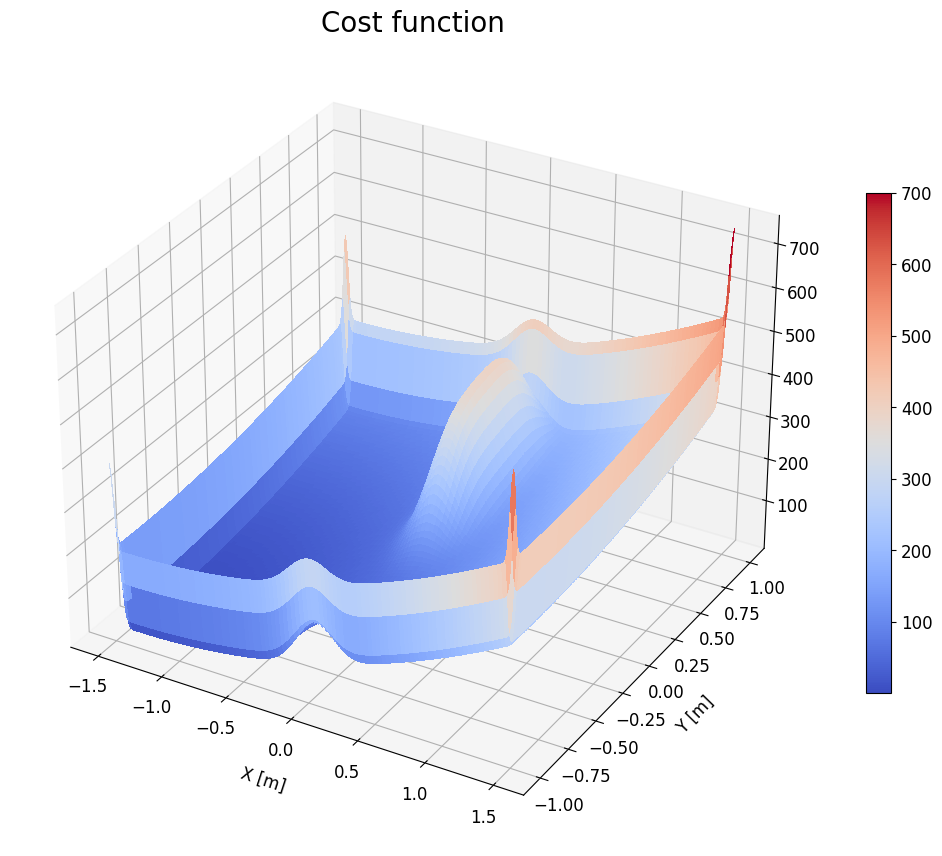

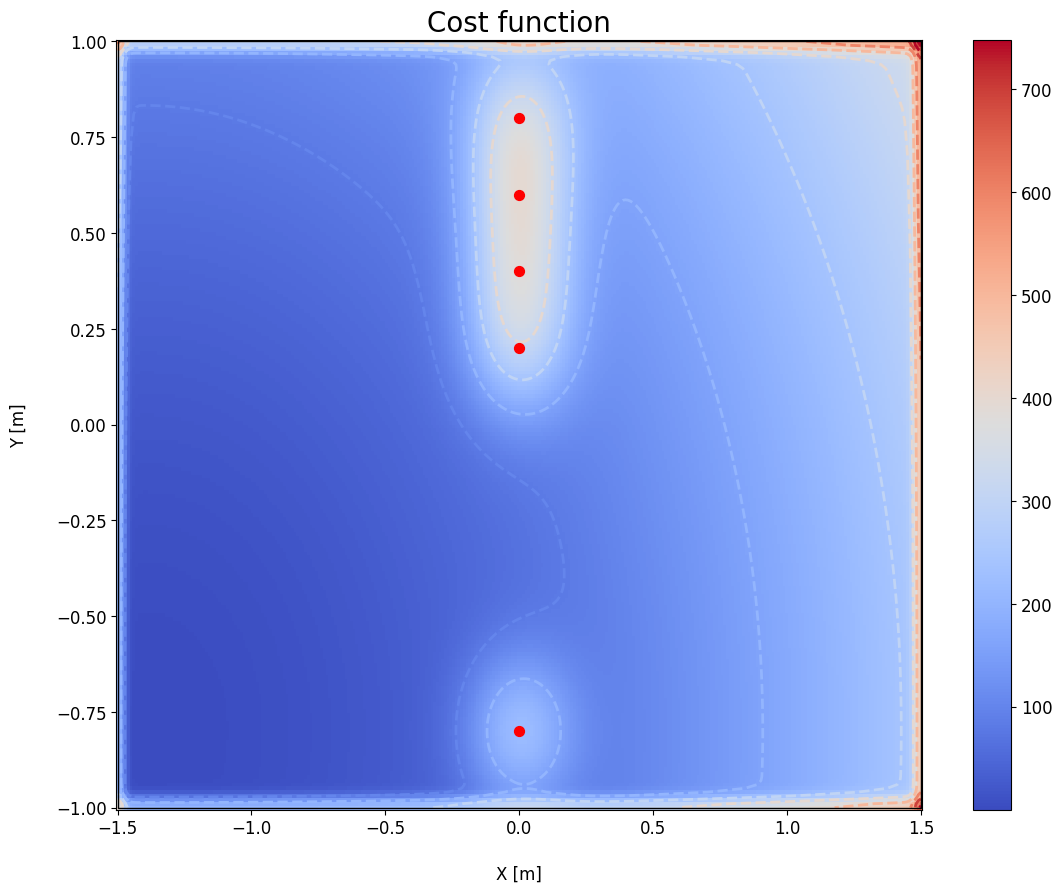

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot()
ax.set_xlabel('X [m]', labelpad=20)
ax.set_ylabel('Y [m]', labelpad=20)
ax.set_title('Cost function', fontdict={'fontsize': 20})

# Plot the heatmap of the cost function
pcolormesh = ax.pcolormesh(X_grid, Y_grid, costs, cmap='coolwarm', shading='auto', zorder=1)

# Plot the level curves of the cost function
contour = ax.contour(X_grid, Y_grid, costs, cmap='coolwarm', levels=10, linewidths=2, linestyles='dashed', zorder=2, alpha=1, vmin=0, vmax=600) #vmin and vmax are used to make the contour lines more visible

# Scatter the obstacle points
ax.scatter(obs_points[0,:], obs_points[1,:], marker='o', s=50, color='red', zorder=3)

# Add a colorbar
fig.colorbar(pcolormesh, ax=ax) 

# Create a rectangle
rectangle = Rectangle((X_LIMITS[0], Y_LIMITS[0]), X_LIMITS[1]-X_LIMITS[0], Y_LIMITS[1]-Y_LIMITS[0], fill=False, color="black", linewidth=1, zorder=3)
# Add the rectangle to the plot
ax.add_patch(rectangle)

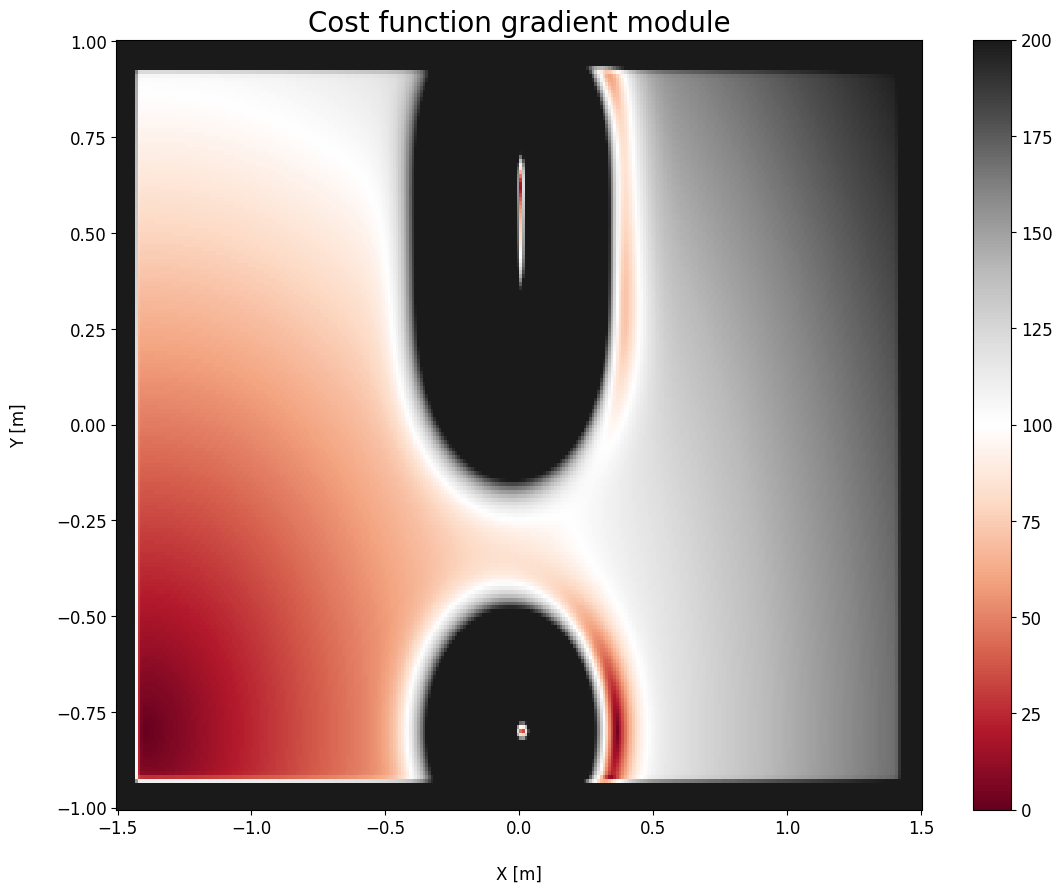

In [81]:
%matplotlib inline
# Calculate the gradient of the cost function
X_grad, Y_grad = np.gradient(costs.T, X_axis, Y_axis) #We need to transpose the costs matrix because we are passing the x axis as the first argument
# Calculate the module of the gradient
Z_grad = np.sqrt(X_grad**2 + Y_grad**2).T #We need to transpose the result because we need to plot it

fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot()
ax.set_xlabel('X [m]', labelpad=20)
ax.set_ylabel('Y [m]', labelpad=20)
ax.set_title('Cost function gradient module', fontdict={'fontsize': 20})

# Plot the heatmap of the module of the gradient of the cost function
pcolormesh = ax.pcolormesh(X_grid, Y_grid, Z_grad, zorder=1, cmap='RdGy', vmin=0, vmax=200)

# Add a colorbar
fig.colorbar(pcolormesh, ax=ax) 

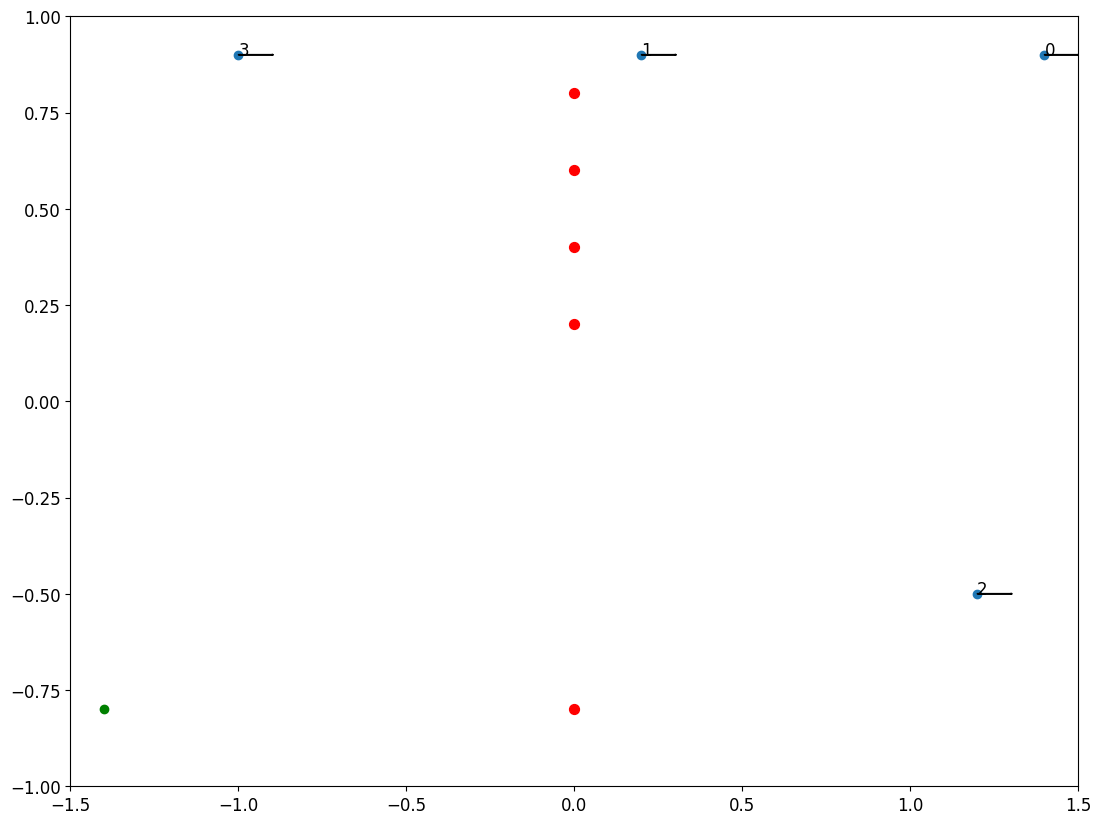

In [82]:
%matplotlib inline
initial_conditions = np.array(initial_conditions).squeeze()
if initial_conditions.ndim == 1:
    initial_conditions = initial_conditions.reshape((1,3))
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot()
ax.scatter(initial_conditions[:,0],initial_conditions[:,1])
ax.scatter(goal_points[0],goal_points[1], color='green')
ax.scatter(obs_points[0,:], obs_points[1,:], marker='o', s=50, color='red', zorder=3)
ax.set_xlim(X_LIMITS)
ax.set_ylim(Y_LIMITS)
l = 0.1
for state_index, state in enumerate(initial_conditions):
    ax.arrow(state[0],state[1],l*np.cos(state[2]),l*np.sin(state[2]))
    ax.annotate(str(state_index),(state[0],state[1]))

# Restore the initial_conditions variable to the original value
initial_conditions = SCENARIOS[selected_scenario]['initial_conditions']

In [83]:
initial_conditions = SCENARIOS[selected_scenario]['initial_conditions']
N_experiment = len(initial_conditions)
X_Si, D_Xi = robotarium_simulation(initial_conditions=initial_conditions, max_iteration=2500, show_simulation=True)

##### DEBUG OUTPUT #####
Your simulation will take approximately 37 real seconds when deployed on the Robotarium. 

	 Simulation had 16427 iteration(s) where the actuator limits were exceeded.
##### DEBUG OUTPUT #####
Your simulation will take approximately 42 real seconds when deployed on the Robotarium. 

	 Simulation had 17531 iteration(s) where the actuator limits were exceeded.
##### DEBUG OUTPUT #####
Your simulation will take approximately 36 real seconds when deployed on the Robotarium. 

	 Simulation had 18498 iteration(s) where the actuator limits were exceeded.
##### DEBUG OUTPUT #####
Your simulation will take approximately 23 real seconds when deployed on the Robotarium. 

	 Simulation had 19093 iteration(s) where the actuator limits were exceeded.


In [84]:
XX = X_Si #Insieme degli stati nel sistema single-integrator (y_1, y_2) per ogni simulazione
UU = D_Xi #Insieme delle azioni di controllo per ogni simulazione

In [85]:
#Prepare data for plotting
X = []
X_plot = []
U = []
U_plot = []

for i in range(len(XX)):
    X.append(np.array(XX[i])) #X=XX ma è un array di array numpy
    X_plot.append(np.array(XX[i])) #X_plot = XX ma è un array numpy
X = np.concatenate(X, axis=0) #X adesso è un array numpy. La prima dimensione contiene le traiettorie di tutti gli esperimenti concatenate e la secoda indicizza lo stato
print(X.shape)
X = np.reshape(X, (-1, 2)) # Rimuove l'ultima dimensione inutile
U = []
for i in range(len(UU)):
    U.append(np.array(UU[i])) #U=UU ma è un array di array numpy
    U_plot.append(np.array(UU[i])) #U_plot=UU ma è un array di array numpy

U = np.concatenate(U, axis=0) #Stessa cosa di prima per le traiettorie di ingresso
U = np.reshape(U, (-1, 2))

(4118, 2, 1)


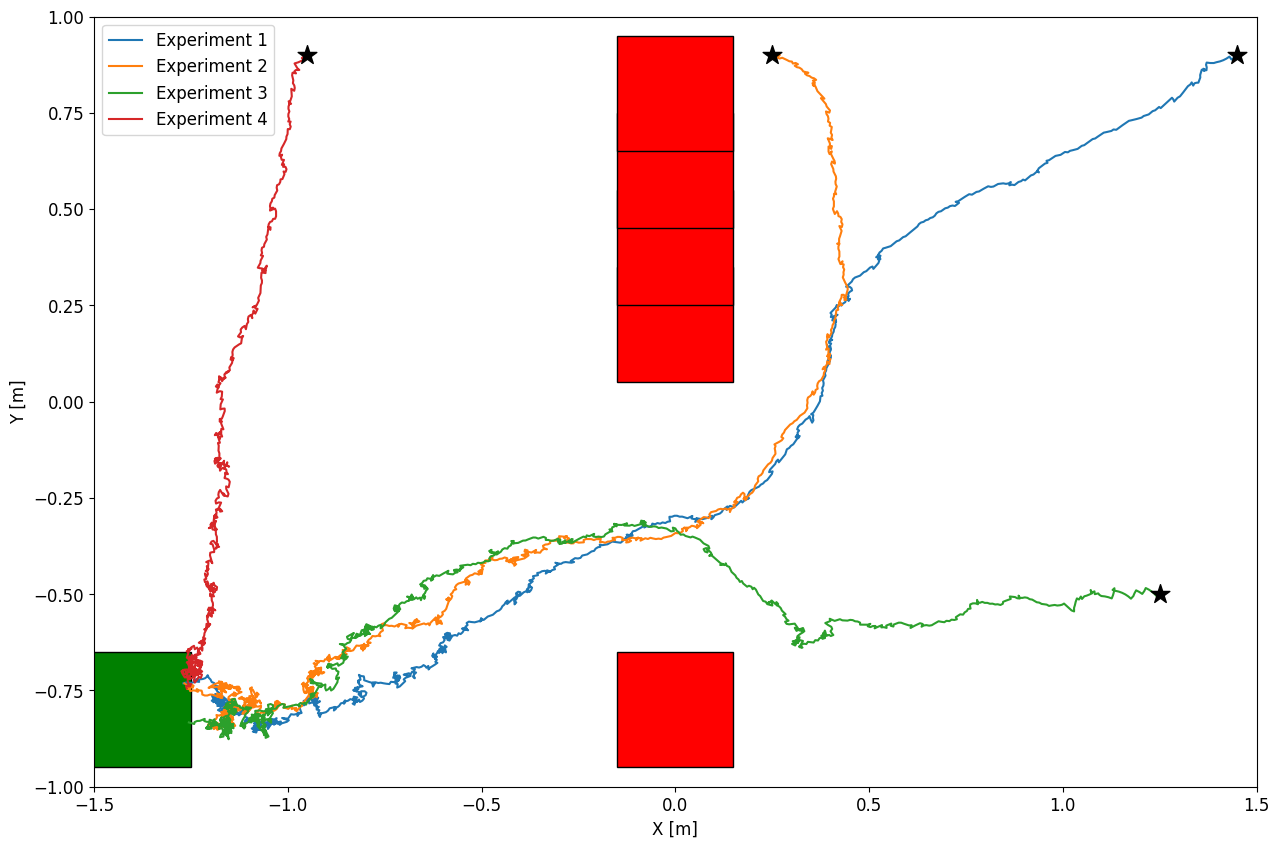

In [86]:
%matplotlib inline
#Task: plot trajectories with different colors
plt.figure(figsize=(15,10))

for I in range(N_experiment):
    trajectory = np.array(X_Si[I])
    plt.plot(trajectory[:,0],trajectory[:,1])

#Add a star to the starting point of each trajectory
for I in range(N_experiment):
    trajectory = np.array(X_Si[I])
    plt.scatter(trajectory[0,0], trajectory[0,1], marker='*', s=200, color='black', zorder=3)

#Add a legend to the plot
legend = []
for i in range(N_experiment):
    legend = legend + ['Experiment {}'.format(i+1)]
    plt.legend(legend)

#Draw obstacles
for i in range(len(obs_points[0])):
    for j in range(len(obs_points[1])):
        if (i==j):
            square=plt.Rectangle((obs_points[0][i]-0.15,obs_points[1][j]-0.15), 0.3, 0.3, fc='red',ec="black")
            plt.gca().add_patch(square)

#Draw goal point
square = plt.Rectangle((float(goal_points[0][0])-0.15,float(goal_points[1][0])-0.15), 0.3, 0.3, fc='green',ec="black") # Obiettivo da raggiungere
plt.gca().add_patch(square)

plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.savefig('Training_Trajectories.jpg',dpi=1000,bbox_inches ='tight')

## Alternative feature

In [87]:
def base_feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32) #vettore delle varianze
    covar = np.diag(v) #matrice di varianze e covarianze
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar) #Modelliamo gli ostacoli come multivariate gaussiane indipendenti (cov=0) centrate nell'ostacolo ipotizzato

    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2)) #La prima feature è relativa al raggiungimento del goal point

    return features

def augmented_feature_walls(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32) #vettore delle varianze
    covar = np.diag(v) #matrice di varianze e covarianze
    features = np.zeros(16)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar) #Modelliamo gli ostacoli come multivariate gaussiane indipendenti (cov=0) centrate nell'ostacolo ipotizzato
    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2)) #La prima feature è relativa al raggiungimento del goal point
    
    x_walls = np.linspace(X_LIMITS[0], X_LIMITS[1], 5)
    y_walls = np.linspace(Y_LIMITS[0], Y_LIMITS[1], 5)
    
    x_wall = lambda x: np.exp(-0.5*((next_state[0]-x)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
    y_wall = lambda y: np.exp(-0.5*((next_state[1]-y)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
    
    for x in x_walls:
        features = np.append(features,x_wall(x))
        
    for y in y_walls:
        features = np.append(features,y_wall(y))
    return features



FEATURES= {
    'baseline': {
        'obs_points_f': np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0')),
        'N_feature': 16,
        'func': base_feature
    },
    'augmented_feature_walls': {
        'obs_points_f': np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0')),
        'N_feature': 26,
        'func': augmented_feature_walls
    },
    'augmented_feature_point': {
        'obs_points_f': np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8 1.2 1.2 1.2 1.2 1.2 0.4 0.4 0.4 0.4 0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -1.2 -1.2 -1.2 -1.2 -1.2; -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ')),
        'N_feature': 36,
        'func': base_feature
    }

}

selected_feature = 'baseline'
feature = FEATURES[selected_feature]['func']
obs_points_f = FEATURES[selected_feature]['obs_points_f']
N_feature = FEATURES[selected_feature]['N_feature'] 


In [121]:
INITIAL_CONDITIONS_BASELINE_IOC = [np.array(np.mat('-1.4;0.9; 0')),np.array(np.mat('1;0.9; 0')),np.array(np.mat('1;-0.25; 0'))]
GOAL_POINTS_BASELINE_IOC = np.array(np.mat('-1.4; -0.8; 0'))
OBS_POINTS_BASELINE_IOC = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))

SCENARIOS_IOC = {
    'baseline': {
        'initial_conditions': INITIAL_CONDITIONS_BASELINE_IOC,
        'goal_points': GOAL_POINTS_BASELINE_IOC,
        'obs_points': OBS_POINTS_BASELINE_IOC
    }
}

selected_scenario_ioc = 'baseline'

In [122]:
goal_points = SCENARIOS_IOC[selected_scenario_ioc]['goal_points']
obs_points = SCENARIOS_IOC[selected_scenario_ioc]['obs_points'] # (3 x n_obstacles) matrix. Each column represents an obstacle. Rows contain the (x,y,theta) of the obstacle.

# Dopo vedremo che questi 'ostacoli' virtuali si mappano a due ostacoli fisici, uno centrato in (0, -0.8) e un altro più lungo centrato in (0, 0.5).

# Define the initial states of the robots
initial_conditions = SCENARIOS_IOC[selected_scenario_ioc]['initial_conditions']

Text(0.5, 1.0, 'Feature points')

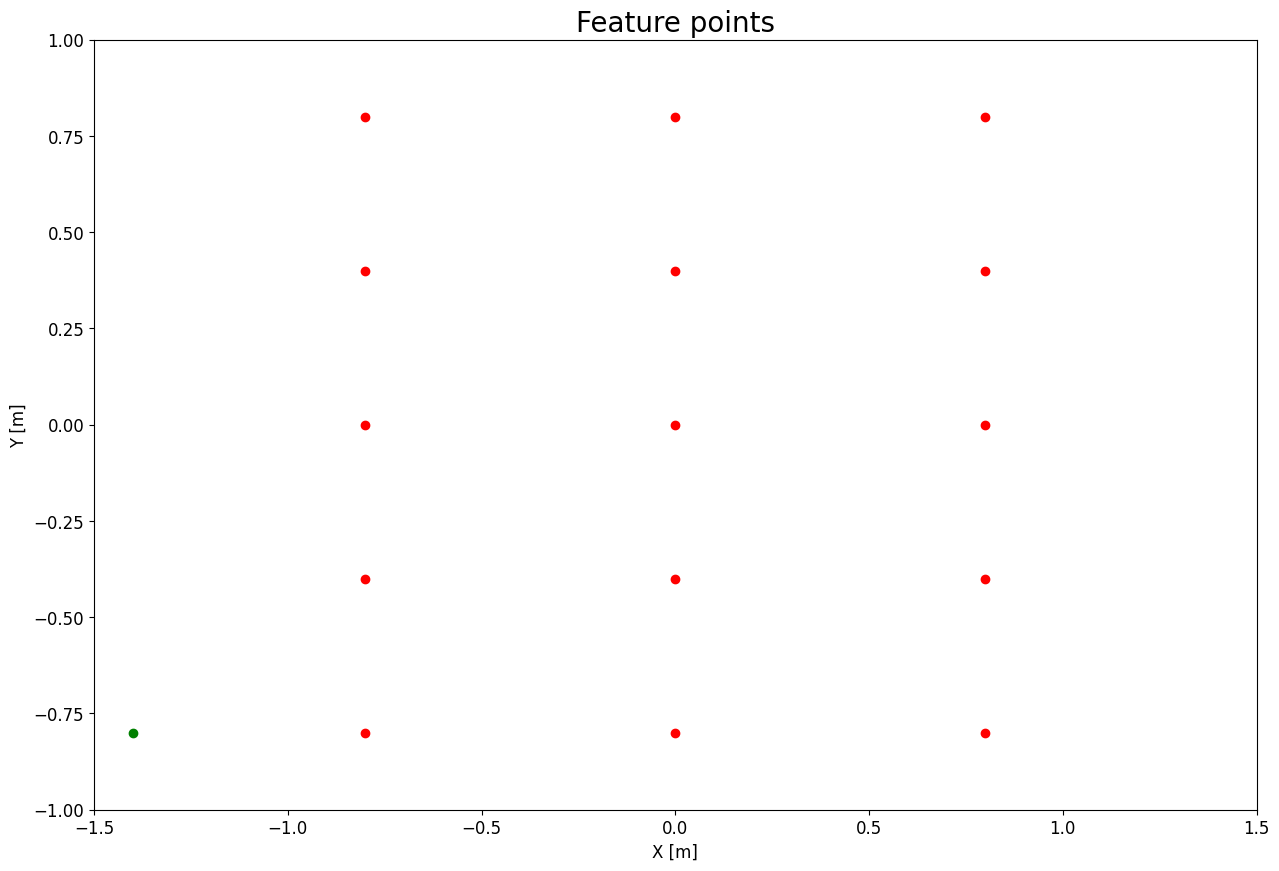

In [123]:
%matplotlib inline
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
ax.scatter(obs_points_f[0,:],obs_points_f[1,:], color='red')
ax.scatter(goal_points[0,:],goal_points[1,:], color='green')
ax.set_ylim(-1,1)
ax.set_xlim(-1.5,1.5)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('Feature points', fontdict={'fontsize': 20})

/tmp/ipykernel_189798/2788757504.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2)) #La prima feature è relativa al raggiungimento del goal point


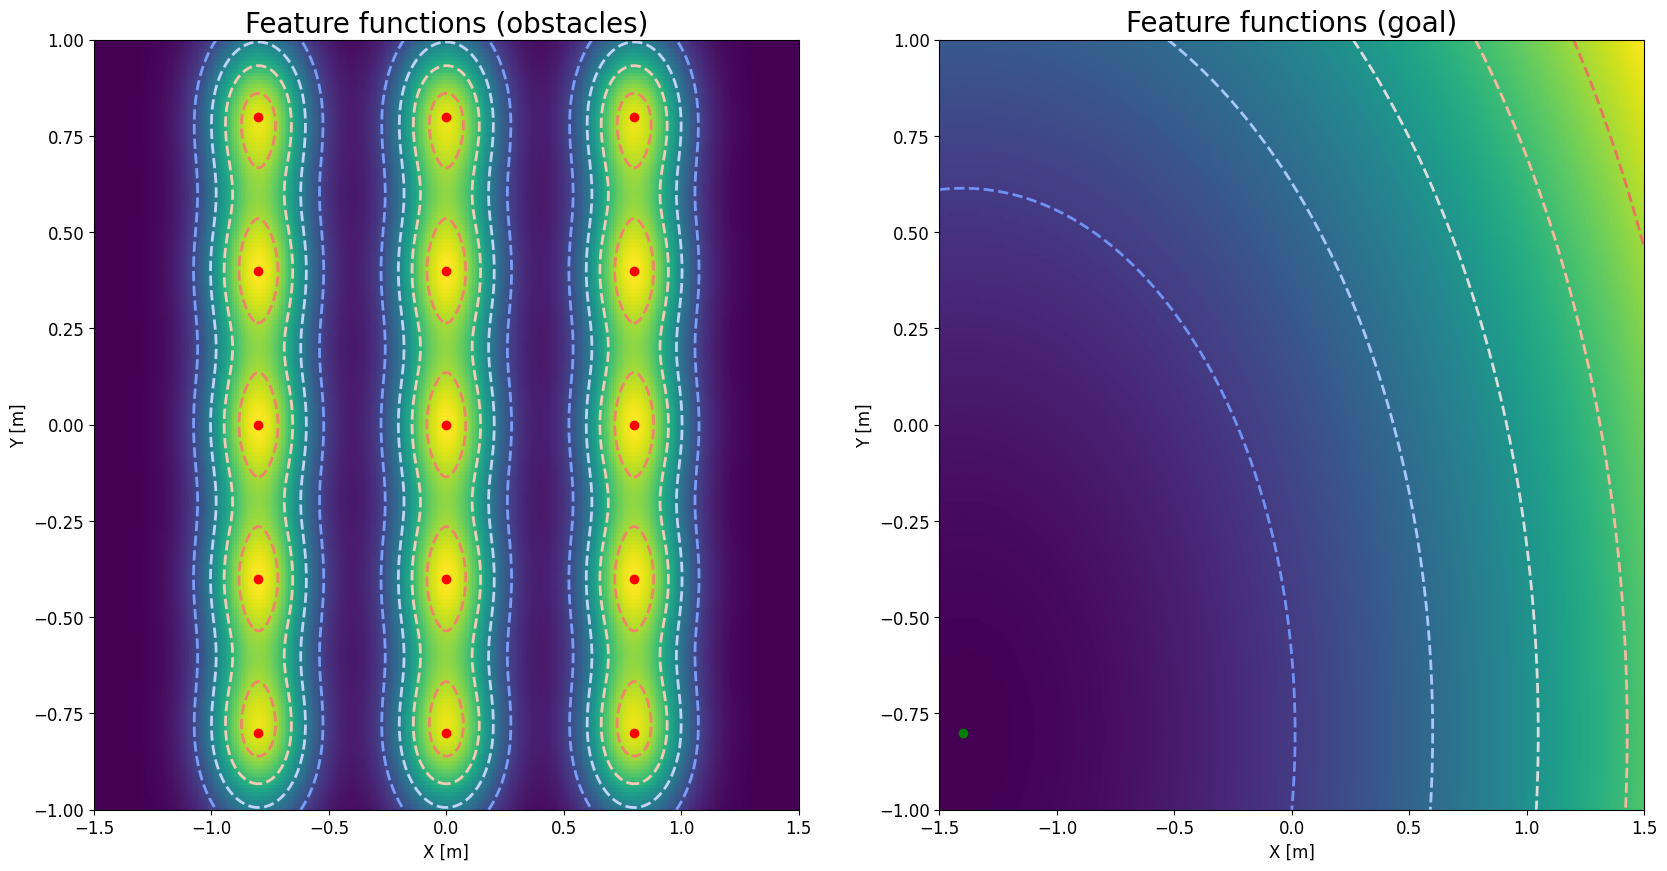

In [124]:
%matplotlib inline

# Define the grid of points where to evaluate the feature function
X_axis = np.linspace(X_LIMITS[0]-EPSILON_LIMITS, X_LIMITS[1]+EPSILON_LIMITS, 300)
Y_axis = np.linspace(Y_LIMITS[0]-EPSILON_LIMITS, Y_LIMITS[1]+EPSILON_LIMITS, 200)
X_grid, Y_grid = np.meshgrid(X_axis, Y_axis)

# Calculate the feature function on the grid
features_array = np.array([[feature((x,y),goal_points,obs_points_f,N_feature) for x in X_axis] for y in Y_axis] ) #TODO: speed up this line by vectorizing it


# Plot the feature functions for the obstacles
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('Feature functions (obstacles)', fontdict={'fontsize': 20})
ax.set_xlim(X_LIMITS[0],X_LIMITS[1])
ax.set_ylim(Y_LIMITS[0],Y_LIMITS[1])

ax.scatter(obs_points_f[0,:],obs_points_f[1,:], color='red', zorder=3)


Z = np.sum(features_array[:,:,1:], axis=-1)
colormesh = ax.pcolormesh(X_grid, Y_grid, Z, shading='auto', zorder=1)
ax.contour(X_grid, Y_grid, Z, cmap='coolwarm', levels=5, linewidths=2, linestyles='dashed', alpha=1, zorder=2) #vmin and vmax are used to make the contour lines more visible

# Plot feature function for the goal
ax = fig.add_subplot(1,2,2)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('Feature functions (goal)', fontdict={'fontsize': 20})
ax.set_xlim(X_LIMITS[0],X_LIMITS[1])
ax.set_ylim(Y_LIMITS[0],Y_LIMITS[1])

ax.scatter(goal_points[0,:],goal_points[1,:], color='green', zorder=3)


Z = features_array[:,:,0]
colormesh = ax.pcolormesh(X_grid, Y_grid, Z, shading='auto', zorder=1)
ax.contour(X_grid, Y_grid, Z, cmap='coolwarm', levels=5, linewidths=2, linestyles='dashed', alpha=1, zorder=2) #vmin and vmax are used to make the contour lines more visible


### Solve the inverse optimal control problem

In [125]:
##### WP4: using the previously defined features solve the inverse optimal control problem. 
#          Plot the estimated cost. 
#          Verify that the estimated cost allows the robot to complete the task #####

In [126]:
%%capture
'''
Solving the convex optimisation problem to learn the cost.
'''
import cvxpy as cp
import numpy as np
import time
M = np.size(X,axis=0) - 1 #size è la lunghezza di tutte le simulazioni concatenate. Concatenare le simulazioni genera 4 termini spuri.
w = cp.Variable((1,N_feature)) #Variabili decisionali. Sono tante quanto il numero di features.
constraints = [w >= 0] #Per hp del problema.
R = np.zeros((99,1)) #??? Mai usato
L = [] #Termini della funzione target da minimizzare (la funzione da minimizzare sum(L))

f_expect = np.zeros((2,20)) #???
feature_sampled = np.zeros((N_feature,M)) #Questo è il valore atteso a sinistra in blu (tranne la moltiplicazione per w che si può portare fuori)
PF = np.zeros((control_space_size,control_space_size,M)) #Questa è la funzione q soprasegnato indicizzata in (u_k, k) dove k è l'indice temporale

for i in range(M): #i è l'i-esimo termine della funzione target da ottimizzare (somma da 1 a M), sto fissando x hat 

    #############################################################################################################################
    features = np.zeros((N_feature,control_space_size,control_space_size)) #Questo è il valore atteso a destra in verde (tranne la moltiplicazione per w che si può portare fuori)
    state = np.array(X[i,:]) #Get the state \hat x_k-1

    x0 = state.reshape(-1,1) #è equivalente alla flatten(), x0 è lo stato iniziale (x0[0],x0[1])
    time_step = 0.033


    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf \overline q(u)

    for j in range(control_space_size):
        for k in range(control_space_size):
            next_state = model_step(state,[U_space_1[j],U_space_2[k]],time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov) #p(x_k|\hat x_k-1, u_k) valutata per \hat x_k-1 e u_k fissati
            #next_sample = f.mean #next_sample = next_state, inutile

            N_samples = 5
            next_samples = f.rvs(N_samples) #5 campioni relativi al prossimo stato. Dimensione 5 campioni x 2 variabili di stato
            feature_sample = np.zeros((N_feature,N_samples)) # 16 feature x 5 campioni

            for m in range(N_samples):
                feature_sample[:,m] = feature(next_samples[m,:],goal_points,obs_points_f,N_feature) #feature_sample è una matrice che tiene sulle colonne le valutazioni delle features sui campioni. Le colonne rorrispondono ai campioni.

            features[:,j,k] = np.mean(feature_sample,axis=1) #la media è fatta su tutti gli elementi della riga [i,;], ovvero per ogni feature i-esima faccio la media su tutti i campioni
            #Alla fine del ciclo features contiene la stima del valore atteso delle features per ogni possibile ingresso (j,k) con \hat x_k-1 fissato
            #quindi ho tutte le stime dei valori attesi a destra in verde nell'equazione. Fatta con la legge dei grandi numeri.
            #Calculate the DKL for each possible input, get corresponding probability
            log_DKL = np.exp(-(-f.entropy())) #Prima parte del valore atteso a destra
            pf[j,k] = log_DKL
    PF[:,:,i] = pf #Prima parte del valore atteso a destra per ogni valore di ingresso e u_k e stato x_k-1

    features = np.reshape(features,(N_feature,control_space_size**2)) # Adesso features ha come primo indice la feature e il secondo va da 0 a 8 e indica l'ingresso di controllo

    f_sampled = model_step(state,U[i+1,:],time_step) # Costuiramo la pdf p(x_k|\hat x_k-1,\hat u_k) che serve a calcolare il valore atteso a sinistra in blu
    cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
    f1 = st.multivariate_normal(f_sampled.reshape((2,)),cov) #p(x_k|\hat x_k-1,\hat u_k)
    next_samples_f1 = f1.rvs(N_samples) #stessa cosa di prima, stima con legge dei grandi numeri del expectation blu a sinistra
    feature_sample_f1 = np.zeros((N_feature,N_samples))
    for n in range(N_samples):
        feature_sample_f1[:,n] = feature(next_samples_f1[n,:],goal_points,obs_points_f,N_feature)

    feature_sampled[:,i] = np.mean(feature_sample_f1,axis=1)  # features_sampled è la stessa cosa di features fatta sul valore atteso blu. nota che u è fissata qunidi non ho come indici j e k. Ho i come indice ed è inutile.

    # Task: solve, using cvx the convex optimization problem we saw in class. To do so:
    # (i) prepare each individual term of the summation, say l;
    # (ii) sum all the elements to define the cost function
    # (iii) solve the problem
    PF2 = np.reshape(PF,(-1,M))
    # log_sum_exp prende in ingresso il vettore colonna degli elmenti da sommare
    l = -(w @ feature_sampled[:,i]) + cp.log_sum_exp(cp.reshape(w@features[:,:],(control_space_size**2,)) + cp.log(PF2[:,i])) #(i)
    L.append(l) #(ii)

objective = cp.Minimize(cp.sum(L)) #(iii)

prob = cp.Problem(objective)

result = prob.solve(verbose = True)

print("status:", prob.status)
print("optimal value", prob.value)

In [ ]:
# Show the values: critically discuss if these weights make sense
weights = w.value

print('weights:',weights)

weights: [[-11.18263479  -5.87143118  -0.06286212  -0.7975133  -12.21725101
   -4.90005057  -1.08162291  -0.60690464   2.54922435   0.40548445
    1.35947097  -0.09540618  -0.15416077  -0.43319605   0.13820114
   -0.20824245]]


In [ ]:
# Check the status of the optimization problem: did the optimization go well? Si
print("status:", prob.status)
print("optimal value", prob.value)

status: optimal
optimal value -8219.277689708977


### Plot the estimated cost function

In [ ]:
# Reformatting the original cost map (just for checking and plotting purposes)

import numpy as np
import scipy.stats as st
import pandas as pd

#goal_points = np.array(np.mat('-1.4; -0.8; 0'))

#obs_points = np.array(np.mat('0 0 0 0 0 0;0 0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0 0'))
#obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))

def state_cost(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost(state,goal_points,obs_points)

#Coat_Map = pd.DataFrame(Cost_Map,index=list(X_axis),columns=Y_axis)

/tmp/ipykernel_189798/888811449.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Cost_Map[j,i] = state_cost(state,goal_points,obs_points)


In [ ]:
# Computing the reconstructed cost map

import numpy as np
import scipy.stats as st

#goal_points = np.array(np.mat('-1.4; -0.8; 0'))

def state_cost_estimated(state,goal_points,obs_points,weights):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1]*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

/tmp/ipykernel_189798/4090227821.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)


Heatmap of the estimated cost function

/tmp/ipykernel_189798/1205842117.py:20: UserWarning: The following kwargs were not used by contour: 'shading'
  contour = ax.contour(X_axis, Y_axis, data_rotated, cmap='coolwarm', shading='linear', levels=7, linewidths=2, linestyles='dashed', zorder=2, alpha=1, vmin=40, vmax=100) #vmin and vmax are used to make the contour lines more visible


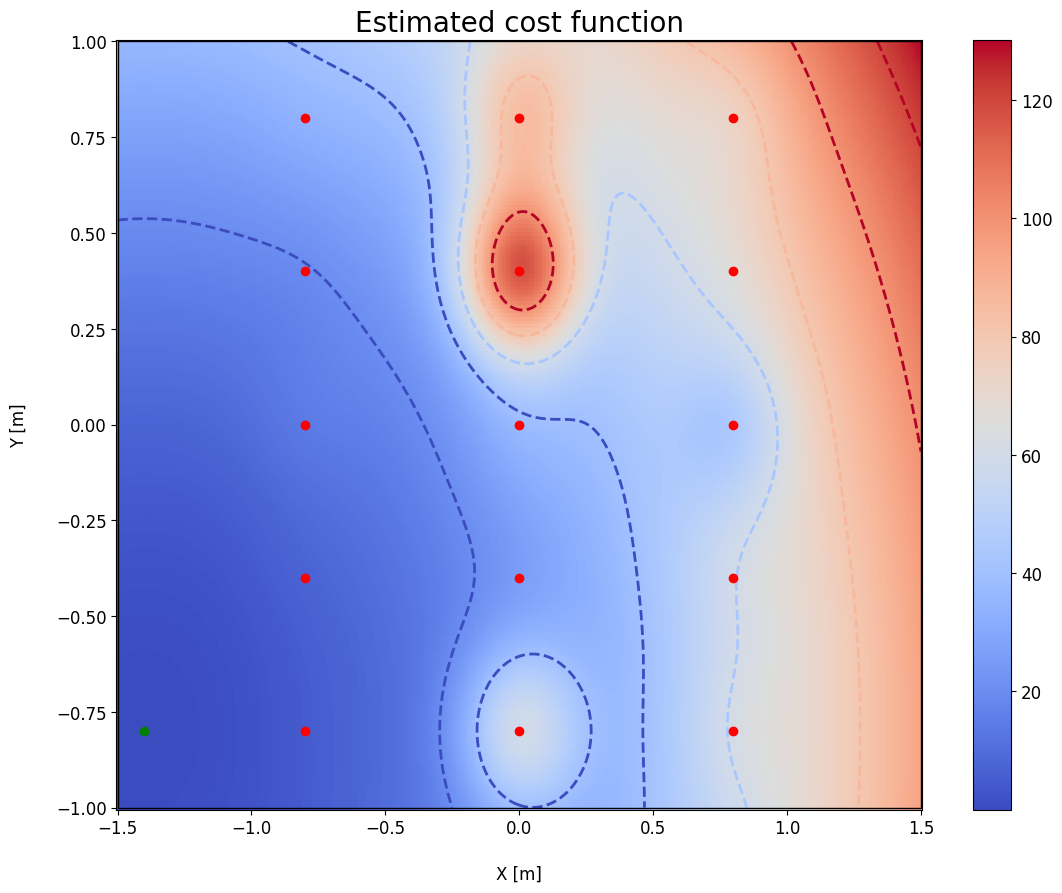

In [ ]:
%matplotlib inline


import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.colors import CenteredNorm
# Transpose the data array to rotate the heatmap
data_rotated = np.transpose(Cost_Map) 
 
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot()
ax.set_xlabel('X [m]', labelpad=20)
ax.set_ylabel('Y [m]', labelpad=20)
ax.set_title('Estimated cost function', fontdict={'fontsize': 20})

# Plot the heatmap of the cost function
pcolormesh = ax.pcolormesh(X_axis, Y_axis, data_rotated, cmap='coolwarm', shading='auto', zorder=1)

# Plot the level curves of the cost function
contour = ax.contour(X_axis, Y_axis, data_rotated, cmap='coolwarm', shading='linear', levels=7, linewidths=2, linestyles='dashed', zorder=2, alpha=1, vmin=40, vmax=100) #vmin and vmax are used to make the contour lines more visible

# Add a colorbar
fig.colorbar(pcolormesh, ax=ax)

# Create a rectangle
rectangle = Rectangle((X_LIMITS[0], Y_LIMITS[0]), X_LIMITS[1]-X_LIMITS[0], Y_LIMITS[1]-Y_LIMITS[0], fill=False, color="black", linewidth=1, zorder=3)
# Add the rectangle to the plot
ax.add_patch(rectangle)
 
plt.scatter(obs_points_f[0,:],obs_points_f[1,:], color='red', zorder=3)
plt.scatter(goal_points[0,:],goal_points[1,:], color='green', zorder=3)

plt.show()




3D plot of the estimated cost function

In [ ]:
%matplotlib tk
# Create a 3D plot
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('X [m]', labelpad=10)
ax.set_ylabel('Y [m]', labelpad=10)
ax.set_zlabel('Cost')
ax.set_title('Estimated Cost Function', fontdict={'fontsize': 20})

surf = ax.plot_surface(X_grid, Y_grid, data_rotated, cmap=cm.coolwarm, linewidth=0, antialiased=False, ccount=100, rcount=100) #rcount and ccount are used to make the surface smoother
fig.colorbar(surf, shrink=0.5)
plt.show()



Controllare se il fattore 6 ha influito sui valori del costo!!!!!

### Simulation with the estimated cost function

We calculate an interpolation of the cost function to speed up the computation of the policy

In [ ]:
from scipy import interpolate

X_axis_interpolation = np.linspace(X_LIMITS[0]-0.5, X_LIMITS[1]+0.5, 600)
Y_axis_interpolation = np.linspace(Y_LIMITS[0]-0.5, Y_LIMITS[1]+0.5, 400)
X_grid_interpolation, Y_grid_interpolation = np.meshgrid(X_axis_interpolation, Y_axis_interpolation)
Z = np.zeros((600,400))
for i in range(600):
    for j in range(400):
        Z[i,j] = state_cost_estimated(np.array([X_axis_interpolation[i],Y_axis_interpolation[j]]),goal_points,obs_points_f,weights)


interpolated_cost = interpolate.LinearNDInterpolator(np.stack((X_grid_interpolation.flatten(),Y_grid_interpolation.flatten()),axis=1),Z.T.flatten())

/tmp/ipykernel_189798/1384910081.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i,j] = state_cost_estimated(np.array([X_axis_interpolation[i],Y_axis_interpolation[j]]),goal_points,obs_points_f,weights)


Plot the interpolated cost function

In [ ]:
#Plot the heatmap of the interpolated cost function
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot()
ax.set_xlabel('X [m]', labelpad=20)
ax.set_ylabel('Y [m]', labelpad=20)
ax.set_title('Interpolated cost function', fontdict={'fontsize': 20})
TEST = np.zeros((600,400))

for i in range(600):
    for j in range(400):
        TEST[i,j] = interpolated_cost(X_axis_interpolation[i], Y_axis_interpolation[j])
pcolormesh = ax.pcolormesh(X_grid_interpolation, Y_grid_interpolation, TEST.T, cmap='coolwarm',  zorder=1)


In [ ]:
#Task: re-define the function Control_step so that it now uses the estimated cost
def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
    ###
    # Perform a control step given the fact that the target pf is uniform.
    # The function first gets the target pf (uniform) and then applies the control solution we saw in class
    
    target_pf = 1/control_space_size**2 # Uniform pf q(u_k|x_k-1)
    time_step = 0.033 # The Robotarium time-step

    pf = np.zeros((control_space_size,control_space_size))
    for i in range(control_space_size):
        for j in range(control_space_size):
            next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov)
            N_samples = 20
            next_sample = f.rvs(N_samples) 

            # Task: what do the next three lines do?
            # Calcola una stima del valore atteso del costo nello stato successivo rispetto alla funzione f(x_k|x_k-1,u_k) usando 20 campioni
            cost=0
            for k in range(N_samples):
                #cost += state_cost_estimated(next_sample[k,:],goal_points,obs_points_f,weights)/N_samples
                cost += interpolated_cost(next_sample[k,:])/N_samples
            log_DKL = np.exp(f.entropy()-cost).item() #item is used to convert the result to a scalar
            pf[i,j] = log_DKL 
    # Task: obtain the normalizer for the policy, call it S2
    S2 = np.sum(pf)
    # Task: obtain the normalized pf (call the variable pf)
    pf = np.divide(pf,S2)

    # Adesso abbiamo p(u_k|x_{k-1}) e facciamo il sampling della prossima azione di controllo
    # This is a trick to properly sample from the multi-dimensional pf
    flat = pf.flatten()
    sample_index = np.random.choice(a=flat.size, p=flat)
    # Take this index and adjust it so it matches the original array
    adjusted_index = np.unravel_index(sample_index, pf.shape) #Indice dell'azione

    #Formatta l'azione come vettore colonna
    action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))
    return(action)

In [ ]:
%matplotlib tk

N_experiment = len(initial_conditions)
X_Si, D_Xi= robotarium_simulation(initial_conditions=initial_conditions, max_iteration=2500, show_simulation=True)


SIMULATION 0 FAILED!
##### DEBUG OUTPUT #####
Your simulation will take approximately 83 real seconds when deployed on the Robotarium. 

	 Simulation had 21287 iteration(s) where the actuator limits were exceeded.
SIMULATION 1 FAILED!
##### DEBUG OUTPUT #####
Your simulation will take approximately 83 real seconds when deployed on the Robotarium. 

	 Simulation had 138 iteration(s) robots were outside the boundaries.

	 Simulation had 23438 iteration(s) where the actuator limits were exceeded.
SIMULATION 2 FAILED!
##### DEBUG OUTPUT #####
Your simulation will take approximately 83 real seconds when deployed on the Robotarium. 

	 Simulation had 138 iteration(s) robots were outside the boundaries.

	 Simulation had 25617 iteration(s) where the actuator limits were exceeded.
SIMULATION 3 FAILED!
##### DEBUG OUTPUT #####
Your simulation will take approximately 83 real seconds when deployed on the Robotarium. 

	 Simulation had 138 iteration(s) robots were outside the boundaries.

	 Simula

In [ ]:
XX = X_Si
UU = D_Xi

In [ ]:
X = []
X_plot = []
U = []
U_plot = []

for i in range(len(XX)):
    X.append(np.array(XX[i]))
    X_plot.append(np.array(XX[i]))

X = np.concatenate(X, axis=0)
X = np.reshape(X, (-1, 2))

U = []
for i in range(len(UU)):
    U.append(np.array(UU[i]))
    U_plot.append(np.array(UU[i]))

U = np.concatenate(U, axis=0)
U = np.reshape(U, (-1, 2))

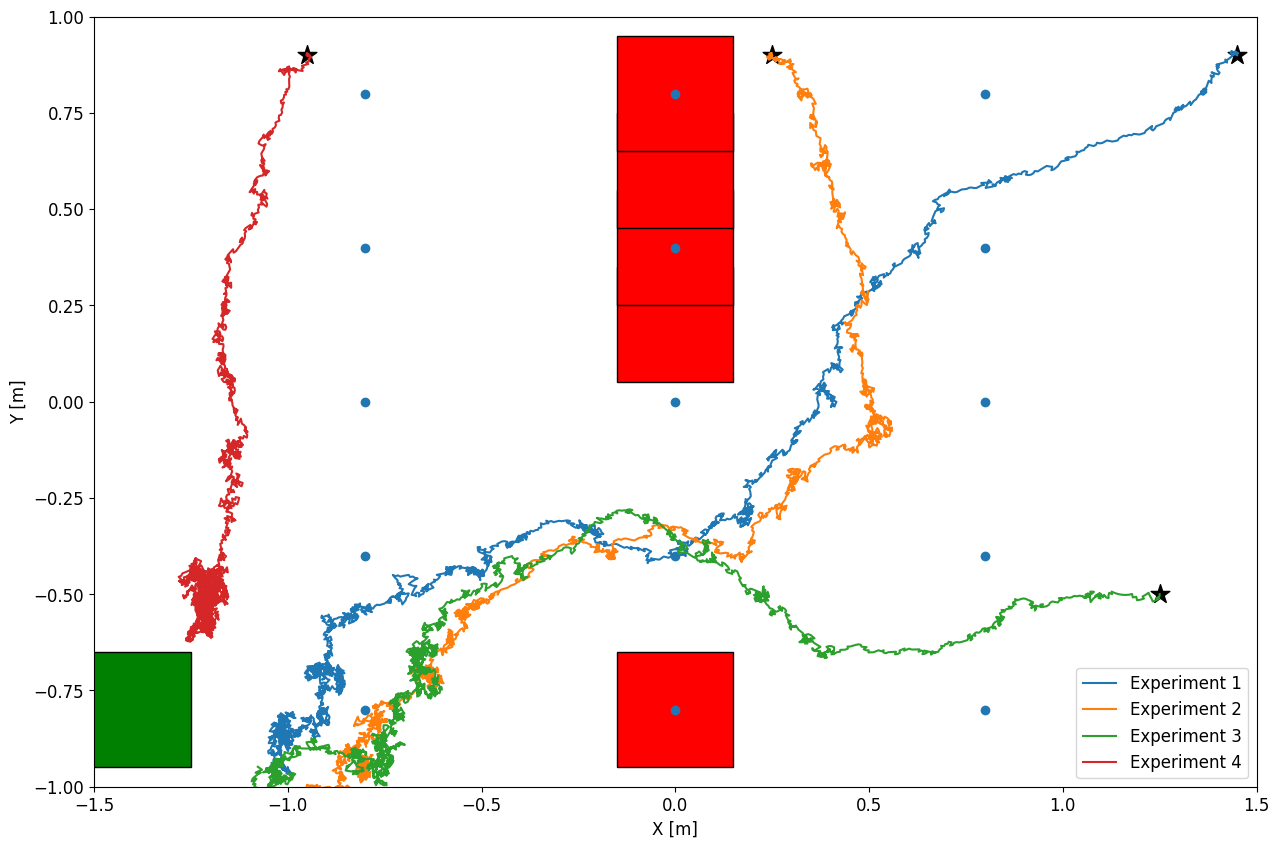

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
%matplotlib inline
#Task: plot trajectories with different colors
plt.figure(figsize=(15,10))

for I in range(N_experiment):
    trajectory = np.array(X_Si[I])
    plt.plot(trajectory[:,0],trajectory[:,1])

# Add a star to the starting point of each trajectory
for I in range(N_experiment):
    trajectory = np.array(X_Si[I])
    plt.scatter(trajectory[0,0], trajectory[0,1], marker='*', s=200, color='black')

# Add a legend to the plot
legend = []
for i in range(N_experiment):
    legend = legend + ['Experiment {}'.format(i+1)]
    plt.legend(legend)


#Draw obstacles
for i in range(len(obs_points[0])):
    for j in range(len(obs_points[1])):
        if (i==j):
            square=plt.Rectangle((obs_points[0][i]-0.15,obs_points[1][j]-0.15), 0.3, 0.3, fc='red',ec="black")
            plt.gca().add_patch(square)

#Draw goal point
square = plt.Rectangle((float(goal_points[0][0])-0.15,float(goal_points[1][0])-0.15), 0.3, 0.3, fc='green',ec="black") # Obiettivo da raggiungere
plt.gca().add_patch(square)

plt.scatter(obs_points_f[0,:],obs_points_f[1,:])

plt.ylim(-1,1)
plt.xlim(-1.5,1.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.show()

[[-11.18263479  -5.87143118  -0.06286212  -0.7975133  -12.21725101
   -4.90005057  -1.08162291  -0.60690464   2.54922435   0.40548445
    1.35947097  -0.09540618  -0.15416077  -0.43319605   0.13820114
   -0.20824245]]


(-1.0, 1.0)

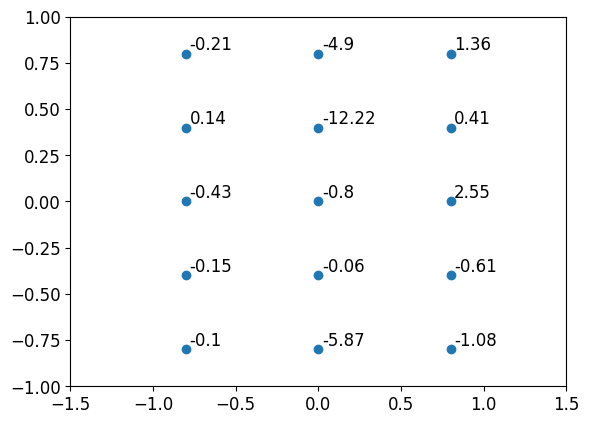

In [ ]:
# Task: plot the feature points on the robotarium grid with corresponding weights
%matplotlib inline

import matplotlib.pyplot as plt
print(weights)
fig, ax = plt.subplots()
ax.scatter(obs_points_f[0,:],obs_points_f[1,:])
for i, w in enumerate(weights[0,1:]):
    ax.annotate(round(w,2), (obs_points_f[0,i] + 0.02, obs_points_f[1,i] + 0.02))

# Set x-axis limits
ax.set_xlim([-1.5, 1.5])

# Set y-axis limits
ax.set_ylim([-1, 1])